In [1]:
import os
from pathlib import Path
import pandas as pd
from lifelines import CoxPHFitter
import numpy as np
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
# import forestplot as fp
from tabulate import tabulate
from matplotlib.ticker import FormatStrFormatter
from lifelines.utils import k_fold_cross_validation

from sklearn.model_selection import StratifiedKFold
from sksurv.linear_model import CoxPHSurvivalAnalysis
from collections import defaultdict
        
from lifelines import KaplanMeierFitter
from lifelines.plotting import add_at_risk_counts
from lifelines.datasets import load_waltons
from contextlib import redirect_stdout
from sksurv.metrics import cumulative_dynamic_auc, concordance_index_censored

import numpy as np
import pandas as pd
import statsmodels.formula.api as smf

from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# boot_conf_intervals_ml.py just concatenates the gists referenced below

# Example usage: 
# from boot_conf_intervals_ml import ci # enough to calc conf intervals
#
# But for more detailed usage like in the article, you might want:
# from boot_conf_intervals_ml import ci, data_args_to_df, make_boot_df \
#    , specificity_score, raw_metric_samples, metric_boot_histogram \
#    #don't need:#     , metrics_from_df, metrics_from_data_args
         
# https://gist.github.com/DavidRosen/356fd5bc7fe74d444c9e971680fadd5e
import numpy as np
import pandas as pd
import re
def data_args_to_df(*data_args):
    return pd.DataFrame( { arg.name if hasattr(arg,'name') else str(i) :
                           np.array(arg)   for i,arg in enumerate(data_args)
                         }# end of dict comprehen.; np.array() removes index
                       )
def make_boot_df(dforig):
    """Returns one boot sample dataframe, same shape as dforig
    """
    return dforig.sample(frac=1,replace=True).reset_index(drop=True)

# https://gist.github.com/DavidRosen/20dc3143d1354eba911a995fb75f81d7
from sklearn import metrics
def specificity_score(true, pred, **kwargs):
    return metrics.recall_score(1-pd.Series(true), 1-pd.Series(pred), **kwargs)
specificity_score.__name__ = "Specificity (Recall of −ve)"

def metrics_from_df(metrics, df, **metric_kwargs):
    data_args=[col_as_arg for (colname,col_as_arg) in df.items()]
    return metrics_from_data_args(metrics, *data_args, **metric_kwargs)
def metrics_from_data_args(metrics, *data_args, **metric_kwargs):
    if callable(metrics): metrics=[metrics] # single metric func to list of
    return   [m(*data_args, **_kws_this_metric(m,**metric_kwargs)) for m in 
      metrics]#end of list comprehension of all metrics applied to *data_args

def _get_default_keywords(metric): # how to make it work on specificity_score??
    return metric.__wrapped__.__kwdefaults__ if \
      ( hasattr(metric,"__wrapped__") and
        hasattr(metric.__wrapped__,"__kwdefaults__") and
        isinstance(metric.__wrapped__.__kwdefaults__, dict) 
      ) else dict() # empty dict if no __kwdefaults__ dict
def _kws_this_metric(metric,**metric_kwargs): # kwargs this metric accepts
    return { k: metric_kwargs[k] for k in # set intersection of keys:
             metric_kwargs.keys() & _get_default_keywords(metric).keys() 
           }# end of dict comprehension to convert keys set back to dict
def _metric_name(metric):
    name=re.sub(' score$','',metric.__name__.replace('_',' '))
    return name.title() if name.lower()==name else name

# https://gist.github.com/DavidRosen/dd79e5e46ae53c2bde63c8a07460a044
from tqdm import trange
DFLT_NBOOTS=1000
def raw_metric_samples(metrics, *data_args, nboots=DFLT_NBOOTS, sort=False,
       **metric_kwargs):
    """Return dataframe containing metric(s) for nboots boot sample datasets.
    metrics is a metric func or iterable of funcs e.g. [m1, m2, m3]
    """
    if callable(metrics): metrics=[metrics] # single metric func to list of
    metrics=list(metrics) # in case it is a generator
    dforig=data_args_to_df(*data_args)
    res=pd.DataFrame( { b: metrics_from_df(metrics, dfboot, **metric_kwargs)
                           for b,dfboot in # generator expr, not huge df list!
                           ((b,make_boot_df(dforig)) for b in trange(nboots))
                           if dfboot.iloc[:,0].nunique()>1 # >1: log loss, roc
                      }, index=[_metric_name(m) for m in metrics]
                    ) # above { b: ... for b,dfboot in... } is dict comprehen.
    res.index.name="Metric (class 1 +ve)"
    return res.apply(lambda row: np.sort(row), axis=1) if sort else res

# https://gist.github.com/DavidRosen/74c35f12ead6a984649f7d6efb9895d2
import matplotlib, matplotlib.ticker as mtick
DFLT_QUANTILES=[0.025,0.975]
def metric_boot_histogram( metric, *data_args, quantiles=DFLT_QUANTILES, 
                           nboots=DFLT_NBOOTS, **metric_kwargs
                         ):
    point = metric(*data_args, **metric_kwargs)
    data = raw_metric_samples(metric, *data_args, **metric_kwargs).transpose()
    (lower, upper) = data.quantile(quantiles).iloc[:,0]
    import seaborn; seaborn.set_style('whitegrid')  #optional
    matplotlib.rcParams["figure.dpi"] = 300
    ax = data.hist(bins=50, figsize=(5, 2), alpha=0.4)[0][0]
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))
    for x in lower, point, upper:
        ax.plot([x, x],[0, 30], lw=2.5)

# https://gist.github.com/DavidRosen/feddfcc657110b56cc6e4a49e20fa4db
def ci( metrics, *data_args, quantiles=DFLT_QUANTILES, 
        nboots=DFLT_NBOOTS, **metric_kwargs
      ):
    """Return Pandas data frame of bootstrap confidence intervals. 
    PARAMETERS:
    metrics : a metric func or iterable of funcs e.g. [m1, m2, m3]
    data_args : 1+ (often 2, e.g. ytrue,ypred) iterables for metric 
    quantiles : [upper,lower] if for 1 CI (dflt is for 95% 2-tail)
    nboots : number of bootstrap samples drawn from data (dflt 500)
    metric_kwargs : each metric gets any KW's it accepts optionally
    """
    if callable(metrics): metrics=[metrics] # single metric func to list of
    metrics=list(metrics) # in case it is a generator [expr]
    result=raw_metric_samples(metrics, *data_args, nboots=nboots, sort=False,
              **metric_kwargs)
    resboots=result.shape[1]
    if resboots<nboots:  # results may be biased if too many were dropped
        print( f'Note: {nboots-resboots} boot sample datasets dropped \n'
               f'(out of {nboots}) because all vals were same in 1st data arg.'
             ) # only 1st data arg because it is probably true target arg
    result=result.apply(lambda row: row.quantile(quantiles),axis=1)
    result.columns=[f'{q*100}%ile' for q in quantiles]
    result.columns.name=f"{resboots} Boot Samples"
    result.insert( 0, "Point Estim", metrics_from_data_args(metrics, 
                                *data_args, **metric_kwargs)
                 ) # inserted (in place) all point estims as first col
    return result


from sksurv.metrics import integrated_brier_score, brier_score

def get_auc_ci(y_test_m, y_predictions_m):
    name_event, name_time = y_test_m.dtype.names
    y_test_new = y_test_m
    va_times = np.arange(y_test_new[y_test_new[name_event]][name_time].min(), y_test_new[y_test_new[name_event]][name_time].max(), 0.2)
    
    cph_auc, cph_mean_auc = cumulative_dynamic_auc(y_test_new, y_test_new, y_predictions_m, va_times)
    # cph_auc, cph_mean_auc = brier_score(y_test_new, y_test_new, y_predictions_m, va_times)

    print (va_times, cph_auc)
    concordance_index = concordance_index_censored(y_test_new[name_event], y_test_new[name_time], y_predictions_m)[0]
    scores =  { 'concordance_index': [concordance_index], 'auc': [pd.Series(cph_auc).mean()]}
    # scores =  { 'concordance_index': [concordance_index], 'auc': [cph_mean_auc], 'auc2': [cph_mean_auc2], 'auc5': [cph_mean_auc5]}

    def get_ci5ss(y_test_index):
                name_event, name_time = y_test_m.dtype.names
                y_test_new = y_test_m[y_test_index]
                y_predictions_new = y_predictions_m[y_test_index]
                va_times = np.arange(y_test_new[y_test_new[name_event]][name_time].min(), y_test_new[y_test_new[name_event]][name_time].max(), 0.2)
                cph_auc, cph_mean_auc = cumulative_dynamic_auc(y_test_new, y_test_new, y_predictions_new, va_times)
                concordance_index = concordance_index_censored(y_test_new[name_event], y_test_new[name_time], y_predictions_new)[0]
                return { 'concordance_index': concordance_index, 'auc': pd.Series(cph_auc).mean()}


    met=[ get_ci5ss ]
    X_metrics_cm = raw_metric_samples(met, np.array(range(len(y_test_m))), nboots=100)
    X_def = defaultdict(list)
    for i in range(len(X_metrics_cm.columns)):
        for key, val in X_metrics_cm.iloc[0][i].items():
                X_def[key].append(val)

    X_def = pd.DataFrame(X_def)

    ci_mean = defaultdict(list)
    for col in X_def.columns:
            
            # ci_lower_auc = np.quantile(X_def[col], 0.025)
            # ci_upper_auc = np.quantile(X_def[col], 0.975)
            mean_auc = scores[col][0]# np.mean(X_def[col])
            # mean_auc = np.quantile(X_def[col], 0.50) # np.mean(X_def[col])
            # print (mean_auc-ci_lower_auc, ci_upper_auc-mean_auc)
            # ci_mean[col].append(f"{round(mean_auc,2)} [{round(ci_lower_auc, 2)}-{round(ci_upper_auc,2)}]")
            
            mean_auc = scores[col][0]
            temp = X_def[col] - mean_auc
            # import pdb; pdb.set_trace()
            ci_lower_auc = mean_auc - np.quantile(temp, 0.975)
            ci_upper_auc = mean_auc - np.quantile(temp, 0.025)
            ci_mean[col].append(f"{round(mean_auc,2)} [{round(ci_lower_auc, 2)}-{round(ci_upper_auc,2)}]")

    ci_mean = pd.DataFrame(ci_mean)
    print (','.join(ci_mean.columns))
    print (','.join(ci_mean.iloc[0]))

In [2]:
from matplotlib.ticker import PercentFormatter
from sklearn.metrics import confusion_matrix
import scipy.stats as stats
import pickle
from dotmap import DotMap
import seaborn as sns
import sys
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as mpatches
import seaborn as sns
from scipy.stats import iqr
import matplotlib.pyplot as plt
import matplotlib as mpl

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sklearn import metrics
from collections import defaultdict
from numpy import interp
from sklearn.metrics import roc_curve, auc, accuracy_score
import numpy as np

from sklearn import metrics
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import copy
from collections import defaultdict
from tabulate import tabulate
import pandas as pd

import seaborn as sns

# sns.set_style({'font.family':'serif', 'font.serif':['Times New Roman'], 'font.serif': 8})
# sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
def get_alls(y_true, y_predictions):
    tn, fp, fn, tp = confusion_matrix(y_true, y_predictions).ravel()
    sensitivity = tp / (tp + fn) # sensitivity, recall, hit rate, or true positive rate (TPR)
    specificity = tn / (tn + fp) # specificity, selectivity or true negative rate (TNR)
    precision = tp / (tp + fp) # precision or positive predictive value (PPV)
    npv = tn / (tn + fn) # negative predictive value (NPV)
    fnr = fn / (fn + tp) # miss rate or false negative rate (FNR)
    tpr = 1 - fnr
    fpr = fp / (fp + tn)# fall-out or false positive rate (FPR)
    tnr = 1 - fpr
    fdr = fp / (fp + tp)
    acc = (tp + tn) / (tp + tn + fp + fn)
    bal_acc = (tpr + tnr) / 2
    f1score = 2 * tp / (2 * tp + fp + fn)   
    incidence = (tp + fn) / (tp + tn + fp + fn)
    class_metrics = {
        "sensitivity": sensitivity,
        "specificity": specificity,
        "precision": precision,
        "ppv": precision,
        "npv": npv,
        "fnr": fnr,
        "tpr": tpr,
        "fpr": fpr,
        "tnr": tnr,
        "fdr": fdr,
        "acc": acc,
        "bal_acc": bal_acc,
        "f1score": f1score, 
        "incidence": incidence,
        'rr': precision / incidence
    }
    # for prevalence in [0.1, 0.01, 0.001]:
    #    ppv = (sensitivity * prevalence) / ((sensitivity * prevalence + (1-specificity) * (1 - prevalence)))
    #    npv = (specificity * (1 - prevalence)) / ((specificity * (1 - prevalence) + (1-sensitivity) * prevalence))
        # class_metrics[f'ppv_{prevalence}'] = ppv
        # class_metrics[f'npv_{prevalence}'] = ppv
        
    return class_metrics
    print ( tn, fp, fn, tp )
    print ("specificity", specificity)
    print ("sensitivity", sensitivity)
    print ("precision", precision)
    print ("npv", npv)
    print ("fnr", fnr)
    print ("tpr", tpr)
    print ("fpr", fpr)
    print ("tnr", tnr)
    print ("fdr", fdr)
    print ("acc", acc)
    print ("bal_acc", bal_acc)
    print ("f1score", f1score)
    print ("f1score", f1score)
    

def cm_analysis(y_true, y_pred, filename, labels, classes, ax, cmap="Blues", ymap=None, figsize=(17,17)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      classes:   aliases for the labels. String array to be shown in the cm plot.
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d' % (p, c)
            #elif c == 0:
            #    annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = confusion_matrix(y_true, y_pred, labels=labels, normalize='true')
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm = cm * 100
    cm.index.name = 'True Label'
    cm.columns.name = 'Predicted Label'
    # fig, ax = plt.subplots(figsize=figsize)
    plt.yticks(va='center')
    sns.heatmap(cm, annot=annot, fmt='', ax=ax, xticklabels=classes, cbar=False, cbar_kws={'format':PercentFormatter()}, yticklabels=classes, cmap=cmap)
    return ax
    # return fig
    # plt.savefig(filename,  bbox_inches='tight')

In [3]:

    
evaluation_generated_dir = Path("/Users/projects_data/project_MLPhenotypesMRIGWAS/evaluation_generated_data/23_03_30") / "survival_analysis_cluster"
organized_generated_dir = Path("/Users/projects_data/project_MLPhenotypesMRIGWAS/organized_data/23_03_30")
os.makedirs(evaluation_generated_dir, exist_ok=True)

data_all = pd.read_parquet(organized_generated_dir / 'combinedData.parquet.gzip')
data_all['id_invicrot1_vol_temporal_rdktlobes'] = 1 - data_all['id_invicrot1_vol_temporal_rdktlobes']
data_all['id_invicrot1_vol_gmtissues'] = 1 - data_all['id_invicrot1_vol_gmtissues']
data_all['id_invicrot1_vol_left_entorhinaldktcortex'] = 1 - data_all['id_invicrot1_vol_left_entorhinaldktcortex']

# subject_max = data_all.set_index('eid')[['Age_i0', 'Age_i1', 'Age_i2', 'Age_i3']].agg(max, axis=1) # - data.set_index('eid')[['Age_i0', 'Age_i1', 'Age_i2', 'Age_i3']].agg(min, axis=1)
subject_max = data_all.set_index('eid')[['Date_of_attending_assessment_centre_i0', 'Date_of_attending_assessment_centre_i1', 'Date_of_attending_assessment_centre_i2', 'Date_of_attending_assessment_centre_i3']].agg(max, axis=1) # - data.set_index('eid')[['Age_i0', 'Age_i1', 'Age_i2', 'Age_i3']].agg(min, axis=1)

subject_max = subject_max.reset_index().groupby('eid').agg('max')[0]
study_time = dict(zip(list(subject_max.index), list(subject_max.values)))

data = data_all[data_all['ukbb_id_nih'].str.contains('20252_2_0')].copy().set_index('eid')
# data['Age_at_image_taken'] = data['Age.when.attended.assessment.centre_nih'].values


MAP = {}
disease_formula = [
    ('PD', f"Sex + PD_prs + Age_at_image_taken + var:norm_PD_imaging_score", '', 3, 5),
    ('PD', f"Sex + Age_at_image_taken + var:norm_PD_imaging_score", '', 3, 5),
    ('PD', f"Sex + var:PD_prs + Age_at_image_taken", '', 3, 5),
    ('PD', f"Sex + var:Age_at_image_taken", '', 3, 5),
    ('PD', f"var:norm_PD_imaging_score", '', 3, 5),
    ('ALL_DEMENTIA', f"Sex + AD_prs + Age_at_image_taken + var:norm_AD_imaging_score", '', 2, 5),
    ('ALL_DEMENTIA', f"Sex + Age_at_image_taken + var:norm_AD_imaging_score", '', 2, 5),
    ('ALL_DEMENTIA', f"Sex + var:AD_prs + Age_at_image_taken", '', 2, 5),
    ('ALL_DEMENTIA', f"Sex + var:Age_at_image_taken", '', 2, 5),
    ('ALL_DEMENTIA', f"var:norm_AD_imaging_score", '', 3, 5),
    ('MCI', 'age_at_image_taken + sex + brainVolume + var:norm_AD_imaging_score', '', 5, 50),
    ('MCI', 'age_at_image_taken + sex + var:brainVolume', '', 5, 50),
    ('MCI', f"var:norm_AD_imaging_score", '', 5, 50),
]
dict_auc = {}
dict_times = {}

D_RESULTS = {}
enm = 0
for disease, temp_formula, ind, time_point1, time_point2 in disease_formula:
        list_variable_of_interest = [var.split(':')[1] for var in temp_formula.split(' + ') if 'var' in var]
        formula = temp_formula.replace('var:', '')
        if not disease == 'MCI':
            # variable_of_interest = formula.split(' + ')[-1]
            fname = f"{disease}&{formula.replace(' + ', '@')}"
            # os.makedirs(evaluation_generated_dir / fname, exist_ok=True)
            duration_col = f"daysFromDiagnosis_image_taken_{disease}"
            data[duration_col] = (data[f'Date_of_{disease}'] - data['Date_of_attending_assessment_centre']) / 365
            # if 'Age_at_image_taken' in data.columns:
            # data['Age_at_image_taken'] = data['Age.when.attended.assessment.centre_nih'].values
            data['Age_at_image_taken'] = (data['Date_of_attending_assessment_centre'] - data['birthMonthYear']) / 365
            
            if disease == 'PD':
                temp_input_data = data.dropna(subset=['Sex', 'PD_prs', 'Age_at_image_taken', 'norm_PD_imaging_score']).copy()
            elif disease == 'ALL_DEMENTIA':
                temp_input_data = data.dropna(subset=['Sex', 'AD_prs', 'Age_at_image_taken', 'norm_AD_imaging_score']).copy()
            else:
                temp_input_data = data.copy()
                
            
            # temp_input_data = temp_input_data[(temp_input_data['Age_at_image_taken'] >= 65) & (temp_input_data['Age_at_image_taken'] <= 75) ]
            
            event_subjects = temp_input_data[(temp_input_data[duration_col] > 0)].index
            event_subjects_data = temp_input_data.loc[event_subjects].copy()
            event_subjects_data[f"Status_{duration_col}"] = 1
            
            
            event_subjects_data.loc[event_subjects_data[duration_col]>5, f"Status_{duration_col}"] = 0 
            event_subjects_data[duration_col] = event_subjects_data[duration_col].map(lambda x: min(x, 5))
            
            # event_subjects_data = event_subjects_data[(event_subjects_data[duration_col]>=time_point1) & (event_subjects_data[duration_col]<time_point2)]
            # upper = event_subjects_data.mean().loc['Age_at_image_taken'] +  event_subjects_data.std().loc['Age_at_image_taken'] 
            # lower = event_subjects_data.mean().loc['Age_at_image_taken'] -  event_subjects_data.std().loc['Age_at_image_taken']


            right_censored_subjects = temp_input_data[temp_input_data[duration_col].isnull()].index
            right_censored_subjects_data = temp_input_data.loc[right_censored_subjects].copy()
            # right_censored_subjects_data[duration_col] = (right_censored_subjects_data.index.map(lambda x: study_time[x]) - right_censored_subjects_data['Age_at_image_taken'])
            right_censored_subjects_data[duration_col] = (right_censored_subjects_data.index.map(lambda x: study_time[x]) - right_censored_subjects_data['Date_of_attending_assessment_centre']) / 365

            right_censored_subjects_data = right_censored_subjects_data[right_censored_subjects_data[duration_col] > 0]
            right_censored_subjects_data[f"Status_{duration_col}"] = 0
            right_censored_subjects_data[duration_col] = right_censored_subjects_data[duration_col].map(lambda x: min(x, 5))

            # right_censored_subjects_data = right_censored_subjects_data[(right_censored_subjects_data['Age_at_image_taken'] >= 65) & (right_censored_subjects_data['Age_at_image_taken'] <= 75) ]
            # right_censored_subjects_data = right_censored_subjects_data[(right_censored_subjects_data['Age_at_image_taken'] < upper) & (right_censored_subjects_data['Age_at_image_taken'] > lower)]
            # right_censored_subjects_data = right_censored_subjects_data.sample(n=1000)
            # event_subjects_greater = event_subjects_data[event_subjects_data[duration_col]>time_point2].index
            # event_subjects_data.loc[event_subjects_greater, f"Status_{duration_col}"] = 0
            # event_subjects_data.loc[event_subjects_greater, duration_col] = time_point2
            # right_censored_subjects_greater = right_censored_subjects_data[right_censored_subjects_data[duration_col]>time_point2].index
            # right_censored_subjects_data.loc[right_censored_subjects_greater, duration_col] = time_point2
            # print (len(event_subjects_data), len(event_subjects_greater), len(right_censored_subjects_data), len(right_censored_subjects_greater)) 

            input_data = pd.concat([event_subjects_data, right_censored_subjects_data], axis=0)
            input_data_columns = formula.split(' + ') + [ duration_col, f"Status_{duration_col}" ]
            input_data_survival = input_data[input_data_columns].copy().dropna(subset=formula.split(' + '))

            input_data_survival_class1 = input_data_survival[input_data_survival[f"Status_{duration_col}"] == 1].copy()
            input_data_survival_class0 = input_data_survival[input_data_survival[f"Status_{duration_col}"] == 0].sample(n=len(input_data_survival_class1)).copy()
            input_data_survival_balanced = pd.concat([input_data_survival_class0, input_data_survival_class1], axis=0)
        else:
            T = pd.read_csv("data/MCI_survival.csv")
            duration_col = f"daysFromDiagnosis_image_taken_{disease}"
            T['norm_AD_imaging_score'] = T['ens_logit_ad_severity_scores'].values
            T[f"daysFromDiagnosis_image_taken_{disease}"] = T['time_from_diagnosis'].values
            T[f"Status_{duration_col}"] = T['event_col'].values
            # T.loc[T[duration_col]>5, f"Status_{duration_col}"] = 0 
            input_data_survival = T.copy()
            input_data_survival.loc[input_data_survival[duration_col]>5, f"Status_{duration_col}"] = 0 
            # input_data_survival[duration_col] = input_data_survival[duration_col].map(lambda x: min(x, 5))
        
            
        if True:
            # input_data_survival = input_data_survival[input_data_survival[duration_col]<=5].copy()
            
            cph_temp = CoxPHFitter()
            # scores = k_fold_cross_validation(cph_temp, input_data_survival, duration_col=duration_col, event_col=f"Status_{duration_col}", formula=formula, k=3)
            cph_temp.fit(input_data_survival, duration_col=duration_col, event_col=f"Status_{duration_col}", formula=formula)
            cph_temp.print_summary()
            print (disease, formula, cph_temp.concordance_index_)
            print (cph_temp.summary)
            cph_temp.summary.to_csv(f"Step3_survival_analysis/Survival_analysis_{disease+ind}.csv")   
            
            
            input_data_survival_norm = input_data_survival.copy()
            means = input_data_survival_norm[list_variable_of_interest[0]].mean()
            stds = input_data_survival_norm[list_variable_of_interest[0]].std()
            input_data_survival_norm['scale' + list_variable_of_interest[0]] = (input_data_survival_norm[list_variable_of_interest[0]] - means) / stds
            cph_temp.fit(input_data_survival_norm, duration_col=duration_col, event_col=f"Status_{duration_col}", formula=formula.replace(list_variable_of_interest[0], 'scale' + list_variable_of_interest[0]))
            cph_temp.print_summary()
            
            
            

            y_main = input_data_survival[[f"Status_{duration_col}", duration_col]].copy()
            y_main[f"Status_{duration_col}"] = y_main[f"Status_{duration_col}"].astype(np.bool_).values
            y_main = y_main.set_index([f"Status_{duration_col}", duration_col]).to_records()
            X_main = input_data_survival[formula.split(' + ')].copy()
            main_estimator = CoxPHSurvivalAnalysis().fit(X_main.astype(float), y_main)
            print (formula, main_estimator.coef_)
                
            results = defaultdict(list)
            skf = StratifiedKFold(n_splits=10)
            S_y = input_data_survival[f"Status_{duration_col}"].copy()
            y_train_list = []
            y_true_values = []
            y_predictions = []
            test_index_list = []
            y_probas_list = []
            y_true_values_list = []
            survs_list = []
            for i, (train_index, test_index) in enumerate(skf.split(input_data_survival, S_y)):
                
                train_input_data_survival = input_data_survival.iloc[train_index].copy()
                test_input_data_survival = input_data_survival.iloc[test_index].copy()

                y_train = train_input_data_survival[[f"Status_{duration_col}", duration_col]].copy()
                y_train[f"Status_{duration_col}"] = y_train[f"Status_{duration_col}"].astype(np.bool_).values
                y_train = y_train.set_index([f"Status_{duration_col}", duration_col]).to_records()
                X_train = train_input_data_survival[formula.split(' + ')].copy()

                y_test = test_input_data_survival[[f"Status_{duration_col}", duration_col]].copy()
                y_test[f"Status_{duration_col}"] = y_test[f"Status_{duration_col}"].astype(np.bool_).values
                y_test = y_test.set_index([f"Status_{duration_col}", duration_col]).to_records()
                X_test = test_input_data_survival[formula.split(' + ')].copy()

                estimator = CoxPHSurvivalAnalysis().fit(X_train.astype(float), y_train)
                concordance_index = estimator.score(X_test, y_test)
                cph_risk_scores = estimator.predict(X_test)
                va_times = np.arange(test_input_data_survival[duration_col].min(), test_input_data_survival[duration_col].max(), 0.1)

                cph_auc, cph_mean_auc = cumulative_dynamic_auc(y_train, y_test, cph_risk_scores, va_times)
                test_index_list.append(test_index)
                y_predictions.append(cph_risk_scores)
                survs_list.extend(estimator.predict_survival_function(X_test))

                
                from sklearn.linear_model import LogisticRegression
                clf = LogisticRegression(random_state=0).fit(X_train, train_input_data_survival[f"Status_{duration_col}"].values)
                y_probas_list.append(clf.predict_proba(X_test))
                y_true_values_list.append(test_input_data_survival[f"Status_{duration_col}"].values)
                
                
                name_event, name_time = y_test.dtype.names
                concordance_index = concordance_index_censored(y_test[name_event], y_test[name_time], cph_risk_scores)[0] 
                results[f'split_type'].append(f"cv{i}")
                results[f'concordance_index'].append(concordance_index)
                results[f'mean_auc'].append(pd.Series(cph_auc).mean())
                
            
            # save results
            test_index_list_m = np.concatenate(test_index_list)
            y_predictions_m = np.concatenate(y_predictions)
            test_input_data_survival = input_data_survival.iloc[test_index_list_m].copy()
            y_test_m = test_input_data_survival[[f"Status_{duration_col}", duration_col]].copy()
            y_test_m[f"Status_{duration_col}"] = y_test_m[f"Status_{duration_col}"].astype(np.bool_).values
            y_test_m = y_test_m.set_index([f"Status_{duration_col}", duration_col]).to_records()
            
            
            D_RESULTS[f"{disease}-{formula}"] = {
                "survival_function": survs_list,
                "cph_risk_scores": np.concatenate(y_predictions),
                "input_data_survival": input_data_survival.iloc[np.concatenate(test_index_list)].copy(),
                "test_index_list_m": np.concatenate(test_index_list),
                "y_test_m": y_test_m
            }
            

<lifelines.CoxPHFitter: fitted with 4996 total observations, 4956 right-censored observations>
             duration col = 'daysFromDiagnosis_image_taken_PD'
                event col = 'Status_daysFromDiagnosis_image_taken_PD'
      baseline estimation = breslow
   number of observations = 4996
number of events observed = 40
   partial log-likelihood = -243.39
         time fit was run = 2023-05-10 20:55:04 UTC

---
                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                     
Age_at_image_taken      0.19       1.21       0.03             0.14             0.24                 1.15                 1.28
PD_prs                  0.35       1.42       0.15             0.05             0.65                 1.05                 1.91
Sex                    -0.30       0.74       0.35            -0.99             0.38                 0.37                 1.47
norm_PD_imaging_score   1.19       3.29       0.30             0.61             1.77                 1.84                 5.88

                        cmp to     z      p   -log2(p)
covariate                                             
Age_at_image_taken        0.00  7.35 <0.005      42.20
PD_prs                    0.00  2.27   0.02       5.44
Sex                       0.00 -0.86   0.39       1.37
norm_PD_imaging_score     0.00  4.01 <0.005      14.00
---
Concordance = 0.87
Partial AIC = 494.79
log-likelihood ratio test = 101.03 on 4 df
-log2(p) of ll-ratio test = 67.19

PD Sex + PD_prs + Age_at_image_taken + norm_PD_imaging_score 0.8729824634525013
                           coef  exp(coef)  se(coef)  coef lower 95%  \
covariate                                                              
Age_at_image_taken     0.193320   1.213271  0.026300        0.141772   
PD_prs                 0.348818   1.417391  0.153407        0.048145   
Sex                   -0.303483   0.738243  0.351045       -0.991518   
norm_PD_imaging_score  1.189991   3.287052  0.296838        0.608199   

                       coef upper 95%  exp(coef) lower 95%  \
covariate                                                    
Age_at_image_taken           0.244867             1.152314   
PD_prs                       0.649490             1.049323   
Sex                          0.384553             0.371013   
norm_PD_imaging_score        1.771783             1.837120   

                       exp(coef) upper 95%  cmp to         z             p  \
covariate                           

<lifelines.CoxPHFitter: fitted with 4996 total observations, 4956 right-censored observations>
             duration col = 'daysFromDiagnosis_image_taken_PD'
                event col = 'Status_daysFromDiagnosis_image_taken_PD'
      baseline estimation = breslow
   number of observations = 4996
number of events observed = 40
   partial log-likelihood = -243.39
         time fit was run = 2023-05-10 20:55:04 UTC

---
                             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                          
Age_at_image_taken           0.19       1.21       0.03             0.14             0.24                 1.15                 1.28
PD_prs                       0.35       1.42       0.15             0.05             0.65                 1.05                 1.91
Sex                         -0.30       0.74       0.35            -0.99             0.38                 0.37                 1.47
scalenorm_PD_imaging_score   0.83       2.29       0.21             0.42             1.23                 1.53                 3.42

                             cmp to     z      p   -log2(p)
covariate                                                  
Age_at_image_taken             0.00  7.35 <0.005      42.20
PD_prs                         0.00  2.27   0.02       5.44
Sex                            0.00 -0.86   0.39       1.37
scalenorm_PD_imaging_score     0.00  4.01 <0.005      14.00
---
Concordance = 0.87
Partial AIC = 494.79
log-likelihood ratio test = 101.03 on 4 df
-log2(p) of ll-ratio test = 67.19

Sex + PD_prs + Age_at_image_taken + norm_PD_imaging_score [-0.30348267  0.34881766  0.1933198   1.18999105]


<lifelines.CoxPHFitter: fitted with 4996 total observations, 4956 right-censored observations>
             duration col = 'daysFromDiagnosis_image_taken_PD'
                event col = 'Status_daysFromDiagnosis_image_taken_PD'
      baseline estimation = breslow
   number of observations = 4996
number of events observed = 40
   partial log-likelihood = -246.02
         time fit was run = 2023-05-10 20:55:06 UTC

---
                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                     
Age_at_image_taken      0.19       1.21       0.03             0.14             0.24                 1.15                 1.27
Sex                    -0.32       0.73       0.35            -1.00             0.37                 0.37                 1.44
norm_PD_imaging_score   1.25       3.48       0.30             0.67             1.83                 1.95                 6.22

                        cmp to     z      p   -log2(p)
covariate                                             
Age_at_image_taken        0.00  7.36 <0.005      42.29
Sex                       0.00 -0.91   0.36       1.46
norm_PD_imaging_score     0.00  4.21 <0.005      15.27
---
Concordance = 0.87
Partial AIC = 498.03
log-likelihood ratio test = 95.78 on 3 df
-log2(p) of ll-ratio test = 66.11

PD Sex + Age_at_image_taken + norm_PD_imaging_score 0.8688770566108512
                           coef  exp(coef)  se(coef)  coef lower 95%  \
covariate                                                              
Age_at_image_taken     0.191334   1.210864  0.026002        0.140371   
Sex                   -0.316444   0.728736  0.348744       -0.999970   
norm_PD_imaging_score  1.247576   3.481892  0.296222        0.666992   

                       coef upper 95%  exp(coef) lower 95%  \
covariate                                                    
Age_at_image_taken           0.242297             1.150701   
Sex                          0.367081             0.367891   
norm_PD_imaging_score        1.828160             1.948368   

                       exp(coef) upper 95%  cmp to         z             p  \
covariate                                                                    
Age_at_image_taken                1.274173     0.0  7.358467  1.860348e-13   
Sex                    

<lifelines.CoxPHFitter: fitted with 4996 total observations, 4956 right-censored observations>
             duration col = 'daysFromDiagnosis_image_taken_PD'
                event col = 'Status_daysFromDiagnosis_image_taken_PD'
      baseline estimation = breslow
   number of observations = 4996
number of events observed = 40
   partial log-likelihood = -246.02
         time fit was run = 2023-05-10 20:55:06 UTC

---
                             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                          
Age_at_image_taken           0.19       1.21       0.03             0.14             0.24                 1.15                 1.27
Sex                         -0.32       0.73       0.35            -1.00             0.37                 0.37                 1.44
scalenorm_PD_imaging_score   0.87       2.38       0.21             0.46             1.27                 1.59                 3.56

                             cmp to     z      p   -log2(p)
covariate                                                  
Age_at_image_taken             0.00  7.36 <0.005      42.29
Sex                            0.00 -0.91   0.36       1.46
scalenorm_PD_imaging_score     0.00  4.21 <0.005      15.27
---
Concordance = 0.87
Partial AIC = 498.03
log-likelihood ratio test = 95.78 on 3 df
-log2(p) of ll-ratio test = 66.11

Sex + Age_at_image_taken + norm_PD_imaging_score [-0.31644435  0.19133426  1.2475758 ]


<lifelines.CoxPHFitter: fitted with 4996 total observations, 4956 right-censored observations>
             duration col = 'daysFromDiagnosis_image_taken_PD'
                event col = 'Status_daysFromDiagnosis_image_taken_PD'
      baseline estimation = breslow
   number of observations = 4996
number of events observed = 40
   partial log-likelihood = -252.85
         time fit was run = 2023-05-10 20:55:08 UTC

---
                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                  
Age_at_image_taken   0.19       1.21       0.03             0.14             0.24                 1.15                 1.28
PD_prs               0.42       1.53       0.16             0.12             0.73                 1.13                 2.07
Sex                  0.17       1.18       0.33            -0.49             0.82                 0.61                 2.26

                     cmp to    z      p   -log2(p)
covariate                                         
Age_at_image_taken     0.00 7.48 <0.005      43.60
PD_prs                 0.00 2.74   0.01       7.33
Sex                    0.00 0.50   0.62       0.69
---
Concordance = 0.84
Partial AIC = 511.70
log-likelihood ratio test = 82.12 on 3 df
-log2(p) of ll-ratio test = 56.36

PD Sex + PD_prs + Age_at_image_taken 0.8422961102833147
                        coef  exp(coef)  se(coef)  coef lower 95%  \
covariate                                                           
Age_at_image_taken  0.193643   1.213663  0.025891        0.142898   
PD_prs              0.424618   1.529006  0.155180        0.120470   
Sex                 0.165186   1.179613  0.332326       -0.486161   

                    coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%  \
covariate                                                                      
Age_at_image_taken        0.244389             1.153612             1.276841   
PD_prs                    0.728766             1.128027             2.072521   
Sex                       0.816534             0.614983             2.262643   

                    cmp to         z             p   -log2(p)  
covariate                                                      
Age_at_image_taken     0.0  7.479147  7.480653e-14  43.603829  
PD_pr

<lifelines.CoxPHFitter: fitted with 4996 total observations, 4956 right-censored observations>
             duration col = 'daysFromDiagnosis_image_taken_PD'
                event col = 'Status_daysFromDiagnosis_image_taken_PD'
      baseline estimation = breslow
   number of observations = 4996
number of events observed = 40
   partial log-likelihood = -252.85
         time fit was run = 2023-05-10 20:55:08 UTC

---
                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                  
Age_at_image_taken   0.19       1.21       0.03             0.14             0.24                 1.15                 1.28
Sex                  0.17       1.18       0.33            -0.49             0.82                 0.61                 2.26
scalePD_prs          0.43       1.54       0.16             0.12             0.74                 1.13                 2.11

                     cmp to    z      p   -log2(p)
covariate                                         
Age_at_image_taken     0.00 7.48 <0.005      43.60
Sex                    0.00 0.50   0.62       0.69
scalePD_prs            0.00 2.74   0.01       7.33
---
Concordance = 0.84
Partial AIC = 511.70
log-likelihood ratio test = 82.12 on 3 df
-log2(p) of ll-ratio test = 56.36

Sex + PD_prs + Age_at_image_taken [0.1651781  0.42461998 0.19364914]


<lifelines.CoxPHFitter: fitted with 4996 total observations, 4956 right-censored observations>
             duration col = 'daysFromDiagnosis_image_taken_PD'
                event col = 'Status_daysFromDiagnosis_image_taken_PD'
      baseline estimation = breslow
   number of observations = 4996
number of events observed = 40
   partial log-likelihood = -256.60
         time fit was run = 2023-05-10 20:55:10 UTC

---
                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                  
Age_at_image_taken   0.19       1.21       0.03             0.14             0.24                 1.15                 1.27
Sex                  0.13       1.14       0.33            -0.52             0.78                 0.59                 2.19

                     cmp to    z      p   -log2(p)
covariate                                         
Age_at_image_taken     0.00 7.37 <0.005      42.42
Sex                    0.00 0.39   0.70       0.52
---
Concordance = 0.84
Partial AIC = 517.19
log-likelihood ratio test = 74.62 on 2 df
-log2(p) of ll-ratio test = 53.83

PD Sex + Age_at_image_taken 0.8416813412384991
                        coef  exp(coef)  se(coef)  coef lower 95%  \
covariate                                                           
Age_at_image_taken  0.189241   1.208332  0.025676        0.138917   
Sex                 0.130350   1.139227  0.333431       -0.523163   

                    coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%  \
covariate                                                                      
Age_at_image_taken        0.239565             1.149028             1.270696   
Sex                       0.783863             0.592643             2.189915   

                    cmp to         z             p   -log2(p)  
covariate                                                      
Age_at_image_taken     0.0  7.370301  1.702436e-13  42.417465  
Sex                    0.0  0.390936  6.958446e-01   0.523163  


<lifelines.CoxPHFitter: fitted with 4996 total observations, 4956 right-censored observations>
             duration col = 'daysFromDiagnosis_image_taken_PD'
                event col = 'Status_daysFromDiagnosis_image_taken_PD'
      baseline estimation = breslow
   number of observations = 4996
number of events observed = 40
   partial log-likelihood = -256.60
         time fit was run = 2023-05-10 20:55:10 UTC

---
                          coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                       
Sex                       0.13       1.14       0.33            -0.52             0.78                 0.59                 2.19
scaleAge_at_image_taken   1.42       4.16       0.19             1.05             1.80                 2.85                 6.07

                          cmp to    z      p   -log2(p)
covariate                                              
Sex                         0.00 0.39   0.70       0.52
scaleAge_at_image_taken     0.00 7.37 <0.005      42.42
---
Concordance = 0.84
Partial AIC = 517.19
log-likelihood ratio test = 74.62 on 2 df
-log2(p) of ll-ratio test = 53.83

Sex + Age_at_image_taken [0.13034545 0.18924365]


<lifelines.CoxPHFitter: fitted with 4996 total observations, 4956 right-censored observations>
             duration col = 'daysFromDiagnosis_image_taken_PD'
                event col = 'Status_daysFromDiagnosis_image_taken_PD'
      baseline estimation = breslow
   number of observations = 4996
number of events observed = 40
   partial log-likelihood = -282.36
         time fit was run = 2023-05-10 20:55:11 UTC

---
                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                     
norm_PD_imaging_score   1.23       3.41       0.28             0.68             1.77                 1.98                 5.90

                        cmp to    z      p   -log2(p)
covariate                                            
norm_PD_imaging_score     0.00 4.40 <0.005      16.51
---
Concordance = 0.68
Partial AIC = 566.72
log-likelihood ratio test = 23.09 on 1 df
-log2(p) of ll-ratio test = 19.31

PD norm_PD_imaging_score 0.6818986985651916
                           coef  exp(coef)  se(coef)  coef lower 95%  \
covariate                                                              
norm_PD_imaging_score  1.228049   3.414563  0.278928        0.681361   

                       coef upper 95%  exp(coef) lower 95%  \
covariate                                                    
norm_PD_imaging_score        1.774738             1.976566   

                       exp(coef) upper 95%  cmp to        z         p  \
covariate                                                               
norm_PD_imaging_score             5.898735     0.0  4.40275  0.000011   

                        -log2(p)  
covariate                         
norm_PD_imaging_score  16.513553  


<lifelines.CoxPHFitter: fitted with 4996 total observations, 4956 right-censored observations>
             duration col = 'daysFromDiagnosis_image_taken_PD'
                event col = 'Status_daysFromDiagnosis_image_taken_PD'
      baseline estimation = breslow
   number of observations = 4996
number of events observed = 40
   partial log-likelihood = -282.36
         time fit was run = 2023-05-10 20:55:11 UTC

---
                             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                          
scalenorm_PD_imaging_score   0.85       2.35       0.19             0.47             1.23                 1.61                 3.43

                             cmp to    z      p   -log2(p)
covariate                                                 
scalenorm_PD_imaging_score     0.00 4.40 <0.005      16.51
---
Concordance = 0.68
Partial AIC = 566.72
log-likelihood ratio test = 23.09 on 1 df
-log2(p) of ll-ratio test = 19.31

norm_PD_imaging_score [1.22817313]


<lifelines.CoxPHFitter: fitted with 5028 total observations, 4962 right-censored observations>
             duration col = 'daysFromDiagnosis_image_taken_ALL_DEMENTIA'
                event col = 'Status_daysFromDiagnosis_image_taken_ALL_DEMENTIA'
      baseline estimation = breslow
   number of observations = 5028
number of events observed = 66
   partial log-likelihood = -377.99
         time fit was run = 2023-05-10 20:55:13 UTC

---
                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                     
AD_prs                  0.10       1.11       0.12            -0.13             0.34                 0.87                 1.41
Age_at_image_taken      0.15       1.16       0.02             0.11             0.19                 1.12                 1.21
Sex                    -0.43       0.65       0.28            -0.97             0.11                 0.38                 1.11
norm_AD_imaging_score   0.40       1.49       0.06             0.29             0.51                 1.34                 1.67

                        cmp to     z      p   -log2(p)
covariate                                             
AD_prs                    0.00  0.85   0.40       1.34
Age_at_image_taken        0.00  7.17 <0.005      40.23
Sex                       0.00 -1.57   0.12       3.12
norm_AD_imaging_score     0.00  7.18 <0.005      40.41
---
Concordance = 0.86
Partial AIC = 763.98
log-likelihood ratio test = 197.52 on 4 df
-log2(p) of ll-ratio test = 135.84

ALL_DEMENTIA Sex + AD_prs + Age_at_image_taken + norm_AD_imaging_score 0.8634772059938518
                           coef  exp(coef)  se(coef)  coef lower 95%  \
covariate                                                              
AD_prs                 0.103107   1.108610  0.121339       -0.134713   
Age_at_image_taken     0.150606   1.162539  0.021018        0.109411   
Sex                   -0.433286   0.648375  0.275197       -0.972663   
norm_AD_imaging_score  0.400630   1.492765  0.055778        0.291308   

                       coef upper 95%  exp(coef) lower 95%  \
covariate                                                    
AD_prs                       0.340927             0.873966   
Age_at_image_taken           0.191801             1.115621   
Sex                          0.106090             0.378075   
norm_AD_imaging_score        0.509953             1.338176   

                       exp(coef) upper 95%  cmp to         z             p  \
covariate                 

<lifelines.CoxPHFitter: fitted with 5028 total observations, 4962 right-censored observations>
             duration col = 'daysFromDiagnosis_image_taken_ALL_DEMENTIA'
                event col = 'Status_daysFromDiagnosis_image_taken_ALL_DEMENTIA'
      baseline estimation = breslow
   number of observations = 5028
number of events observed = 66
   partial log-likelihood = -377.99
         time fit was run = 2023-05-10 20:55:13 UTC

---
                             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                          
AD_prs                       0.10       1.11       0.12            -0.13             0.34                 0.87                 1.41
Age_at_image_taken           0.15       1.16       0.02             0.11             0.19                 1.12                 1.21
Sex                         -0.43       0.65       0.28            -0.97             0.11                 0.38                 1.11
scalenorm_AD_imaging_score   0.58       1.78       0.08             0.42             0.74                 1.52                 2.09

                             cmp to     z      p   -log2(p)
covariate                                                  
AD_prs                         0.00  0.85   0.40       1.34
Age_at_image_taken             0.00  7.17 <0.005      40.23
Sex                            0.00 -1.57   0.12       3.12
scalenorm_AD_imaging_score     0.00  7.18 <0.005      40.41
---
Concordance = 0.86
Partial AIC = 763.98
log-likelihood ratio test = 197.52 on 4 df
-log2(p) of ll-ratio test = 135.84

Sex + AD_prs + Age_at_image_taken + norm_AD_imaging_score [-0.43354178  0.10320143  0.15054184  0.40066834]


<lifelines.CoxPHFitter: fitted with 5028 total observations, 4962 right-censored observations>
             duration col = 'daysFromDiagnosis_image_taken_ALL_DEMENTIA'
                event col = 'Status_daysFromDiagnosis_image_taken_ALL_DEMENTIA'
      baseline estimation = breslow
   number of observations = 5028
number of events observed = 66
   partial log-likelihood = -378.35
         time fit was run = 2023-05-10 20:55:15 UTC

---
                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                     
Age_at_image_taken      0.15       1.16       0.02             0.11             0.19                 1.12                 1.21
Sex                    -0.43       0.65       0.27            -0.97             0.10                 0.38                 1.11
norm_AD_imaging_score   0.42       1.53       0.05             0.33             0.52                 1.39                 1.68

                        cmp to     z      p   -log2(p)
covariate                                             
Age_at_image_taken        0.00  7.18 <0.005      40.39
Sex                       0.00 -1.58   0.11       3.14
norm_AD_imaging_score     0.00  8.69 <0.005      57.92
---
Concordance = 0.86
Partial AIC = 762.70
log-likelihood ratio test = 196.80 on 3 df
-log2(p) of ll-ratio test = 138.47

ALL_DEMENTIA Sex + Age_at_image_taken + norm_AD_imaging_score 0.8637253415309962
                           coef  exp(coef)  se(coef)  coef lower 95%  \
covariate                                                              
Age_at_image_taken     0.150775   1.162735  0.020999        0.109619   
Sex                   -0.433863   0.648001  0.274051       -0.970993   
norm_AD_imaging_score  0.424037   1.528119  0.048805        0.328381   

                       coef upper 95%  exp(coef) lower 95%  \
covariate                                                    
Age_at_image_taken           0.191931             1.115852   
Sex                          0.103266             0.378707   
norm_AD_imaging_score        0.519693             1.388719   

                       exp(coef) upper 95%  cmp to         z             p  \
covariate                                                                    
Age_at_image_taken                1.211587     0.0  7.180255  6.958156e-13   
Sex          

<lifelines.CoxPHFitter: fitted with 5028 total observations, 4962 right-censored observations>
             duration col = 'daysFromDiagnosis_image_taken_ALL_DEMENTIA'
                event col = 'Status_daysFromDiagnosis_image_taken_ALL_DEMENTIA'
      baseline estimation = breslow
   number of observations = 5028
number of events observed = 66
   partial log-likelihood = -378.35
         time fit was run = 2023-05-10 20:55:16 UTC

---
                             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                          
Age_at_image_taken           0.15       1.16       0.02             0.11             0.19                 1.12                 1.21
Sex                         -0.43       0.65       0.27            -0.97             0.10                 0.38                 1.11
scalenorm_AD_imaging_score   0.61       1.84       0.07             0.47             0.75                 1.61                 2.12

                             cmp to     z      p   -log2(p)
covariate                                                  
Age_at_image_taken             0.00  7.18 <0.005      40.39
Sex                            0.00 -1.58   0.11       3.14
scalenorm_AD_imaging_score     0.00  8.69 <0.005      57.92
---
Concordance = 0.86
Partial AIC = 762.70
log-likelihood ratio test = 196.80 on 3 df
-log2(p) of ll-ratio test = 138.47

Sex + Age_at_image_taken + norm_AD_imaging_score [-0.43415339  0.15070922  0.42409167]


<lifelines.CoxPHFitter: fitted with 5028 total observations, 4962 right-censored observations>
             duration col = 'daysFromDiagnosis_image_taken_ALL_DEMENTIA'
                event col = 'Status_daysFromDiagnosis_image_taken_ALL_DEMENTIA'
      baseline estimation = breslow
   number of observations = 5028
number of events observed = 66
   partial log-likelihood = -402.51
         time fit was run = 2023-05-10 20:55:19 UTC

---
                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                  
AD_prs               0.43       1.54       0.11             0.21             0.65                 1.24                 1.92
Age_at_image_taken   0.19       1.21       0.02             0.15             0.23                 1.17                 1.26
Sex                 -0.03       0.97       0.25            -0.53             0.47                 0.59                 1.60

                     cmp to     z      p   -log2(p)
covariate                                          
AD_prs                 0.00  3.89 <0.005      13.28
Age_at_image_taken     0.00  9.62 <0.005      70.29
Sex                    0.00 -0.12   0.91       0.14
---
Concordance = 0.83
Partial AIC = 811.01
log-likelihood ratio test = 148.49 on 3 df
-log2(p) of ll-ratio test = 103.82

ALL_DEMENTIA Sex + AD_prs + Age_at_image_taken 0.8285176658717139
                        coef  exp(coef)  se(coef)  coef lower 95%  \
covariate                                                           
AD_prs              0.432378   1.540917  0.111153        0.214523   
Age_at_image_taken  0.193400   1.213369  0.020114        0.153977   
Sex                -0.029936   0.970507  0.253699       -0.527177   

                    coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%  \
covariate                                                                      
AD_prs                    0.650233             1.239270             1.915987   
Age_at_image_taken        0.232824             1.166464             1.262159   
Sex                       0.467305             0.590269             1.595688   

                    cmp to         z             p   -log2(p)  
covariate                                                      
AD_prs                 0.0  3.889949  1.002652e-04  13.2838

<lifelines.CoxPHFitter: fitted with 5028 total observations, 4962 right-censored observations>
             duration col = 'daysFromDiagnosis_image_taken_ALL_DEMENTIA'
                event col = 'Status_daysFromDiagnosis_image_taken_ALL_DEMENTIA'
      baseline estimation = breslow
   number of observations = 5028
number of events observed = 66
   partial log-likelihood = -402.51
         time fit was run = 2023-05-10 20:55:19 UTC

---
                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                  
Age_at_image_taken   0.19       1.21       0.02             0.15             0.23                 1.17                 1.26
Sex                 -0.03       0.97       0.25            -0.53             0.47                 0.59                 1.60
scaleAD_prs          0.42       1.53       0.11             0.21             0.64                 1.23                 1.89

                     cmp to     z      p   -log2(p)
covariate                                          
Age_at_image_taken     0.00  9.62 <0.005      70.29
Sex                    0.00 -0.12   0.91       0.14
scaleAD_prs            0.00  3.89 <0.005      13.28
---
Concordance = 0.83
Partial AIC = 811.01
log-likelihood ratio test = 148.49 on 3 df
-log2(p) of ll-ratio test = 103.82

Sex + AD_prs + Age_at_image_taken [-0.02998602  0.43238289  0.19333608]


<lifelines.CoxPHFitter: fitted with 5028 total observations, 4962 right-censored observations>
             duration col = 'daysFromDiagnosis_image_taken_ALL_DEMENTIA'
                event col = 'Status_daysFromDiagnosis_image_taken_ALL_DEMENTIA'
      baseline estimation = breslow
   number of observations = 5028
number of events observed = 66
   partial log-likelihood = -409.72
         time fit was run = 2023-05-10 20:55:21 UTC

---
                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                  
Age_at_image_taken   0.20       1.22       0.02             0.16             0.24                 1.17                 1.27
Sex                 -0.03       0.98       0.25            -0.52             0.47                 0.59                 1.60

                     cmp to     z      p   -log2(p)
covariate                                          
Age_at_image_taken     0.00  9.72 <0.005      71.84
Sex                    0.00 -0.10   0.92       0.12
---
Concordance = 0.82
Partial AIC = 823.45
log-likelihood ratio test = 134.05 on 2 df
-log2(p) of ll-ratio test = 96.70

ALL_DEMENTIA Sex + Age_at_image_taken 0.8165761431466343
                        coef  exp(coef)  se(coef)  coef lower 95%  \
covariate                                                           
Age_at_image_taken  0.199197   1.220423  0.020483        0.159051   
Sex                -0.025024   0.975287  0.252290       -0.519502   

                    coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%  \
covariate                                                                      
Age_at_image_taken        0.239344             1.172398             1.270415   
Sex                       0.469455             0.594817             1.599122   

                    cmp to         z             p   -log2(p)  
covariate                                                      
Age_at_image_taken     0.0  9.724876  2.361936e-22  71.842448  
Sex                    0.0 -0.099187  9.209900e-01   0.118743  


<lifelines.CoxPHFitter: fitted with 5028 total observations, 4962 right-censored observations>
             duration col = 'daysFromDiagnosis_image_taken_ALL_DEMENTIA'
                event col = 'Status_daysFromDiagnosis_image_taken_ALL_DEMENTIA'
      baseline estimation = breslow
   number of observations = 5028
number of events observed = 66
   partial log-likelihood = -409.72
         time fit was run = 2023-05-10 20:55:21 UTC

---
                          coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                       
Sex                      -0.03       0.98       0.25            -0.52             0.47                 0.59                 1.60
scaleAge_at_image_taken   1.51       4.51       0.15             1.20             1.81                 3.33                 6.11

                          cmp to     z      p   -log2(p)
covariate                                               
Sex                         0.00 -0.10   0.92       0.12
scaleAge_at_image_taken     0.00  9.72 <0.005      71.84
---
Concordance = 0.82
Partial AIC = 823.45
log-likelihood ratio test = 134.05 on 2 df
-log2(p) of ll-ratio test = 96.70

Sex + Age_at_image_taken [-0.02521444  0.19912747]


<lifelines.CoxPHFitter: fitted with 5028 total observations, 4962 right-censored observations>
             duration col = 'daysFromDiagnosis_image_taken_ALL_DEMENTIA'
                event col = 'Status_daysFromDiagnosis_image_taken_ALL_DEMENTIA'
      baseline estimation = breslow
   number of observations = 5028
number of events observed = 66
   partial log-likelihood = -410.89
         time fit was run = 2023-05-10 20:55:22 UTC

---
                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                     
norm_AD_imaging_score   0.59       1.80       0.04             0.51             0.67                 1.66                 1.95

                        cmp to     z      p   -log2(p)
covariate                                             
norm_AD_imaging_score     0.00 14.49 <0.005     155.73
---
Concordance = 0.81
Partial AIC = 823.78
log-likelihood ratio test = 131.72 on 1 df
-log2(p) of ll-ratio test = 98.87

ALL_DEMENTIA norm_AD_imaging_score 0.810445127583022
                           coef  exp(coef)  se(coef)  coef lower 95%  \
covariate                                                              
norm_AD_imaging_score  0.588955   1.802104  0.040635        0.509312   

                       coef upper 95%  exp(coef) lower 95%  \
covariate                                                    
norm_AD_imaging_score        0.668598             1.664147   

                       exp(coef) upper 95%  cmp to          z             p  \
covariate                                                                     
norm_AD_imaging_score             1.951499     0.0  14.493897  1.324129e-47   

                         -log2(p)  
covariate                          
norm_AD_imaging_score  155.725577  


<lifelines.CoxPHFitter: fitted with 5028 total observations, 4962 right-censored observations>
             duration col = 'daysFromDiagnosis_image_taken_ALL_DEMENTIA'
                event col = 'Status_daysFromDiagnosis_image_taken_ALL_DEMENTIA'
      baseline estimation = breslow
   number of observations = 5028
number of events observed = 66
   partial log-likelihood = -410.89
         time fit was run = 2023-05-10 20:55:23 UTC

---
                             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                          
scalenorm_AD_imaging_score   0.85       2.34       0.06             0.73             0.96                 2.08                 2.62

                             cmp to     z      p   -log2(p)
covariate                                                  
scalenorm_AD_imaging_score     0.00 14.49 <0.005     155.73
---
Concordance = 0.81
Partial AIC = 823.78
log-likelihood ratio test = 131.72 on 1 df
-log2(p) of ll-ratio test = 98.87

norm_AD_imaging_score [0.58893857]


<lifelines.CoxPHFitter: fitted with 749 total observations, 708 right-censored observations>
             duration col = 'daysFromDiagnosis_image_taken_MCI'
                event col = 'Status_daysFromDiagnosis_image_taken_MCI'
      baseline estimation = breslow
   number of observations = 749
number of events observed = 41
   partial log-likelihood = -213.42
         time fit was run = 2023-05-10 20:55:24 UTC

---
                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                     
age_at_image_taken     -0.04       0.96       0.02            -0.09             0.00                 0.92                 1.00
brainVolume            -1.13       0.32       3.02            -7.04             4.78                 0.00               118.80
norm_AD_imaging_score   0.41       1.50       0.05             0.31             0.50                 1.37                 1.65
sex                     0.06       1.06       0.40            -0.73             0.84                 0.48                 2.33

                        cmp to     z      p   -log2(p)
covariate                                             
age_at_image_taken        0.00 -1.81   0.07       3.83
brainVolume               0.00 -0.38   0.71       0.50
norm_AD_imaging_score     0.00  8.37 <0.005      53.95
sex                       0.00  0.15   0.88       0.18
---
Concordance = 0.86
Partial AIC = 434.84
log-likelihood ratio test = 67.54 on 4 df
-log2(p) of ll-ratio test = 43.60

MCI age_at_image_taken + sex + brainVolume + norm_AD_imaging_score 0.8606584272120749
                           coef  exp(coef)  se(coef)  coef lower 95%  \
covariate                                                              
age_at_image_taken    -0.042186   0.958691  0.023291       -0.087836   
brainVolume           -1.131907   0.322418  3.015008       -7.041214   
norm_AD_imaging_score  0.407011   1.502320  0.048627        0.311704   
sex                    0.059217   1.061006  0.400272       -0.725301   

                       coef upper 95%  exp(coef) lower 95%  \
covariate                                                    
age_at_image_taken           0.003463             0.915912   
brainVolume                  4.777401             0.000875   
norm_AD_imaging_score        0.502317             1.365750   
sex                          0.843736             0.484179   

                       exp(coef) upper 95%  cmp to         z             p  \
covariate                     

<lifelines.CoxPHFitter: fitted with 749 total observations, 708 right-censored observations>
             duration col = 'daysFromDiagnosis_image_taken_MCI'
                event col = 'Status_daysFromDiagnosis_image_taken_MCI'
      baseline estimation = breslow
   number of observations = 749
number of events observed = 41
   partial log-likelihood = -213.42
         time fit was run = 2023-05-10 20:55:24 UTC

---
                             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                          
age_at_image_taken          -0.04       0.96       0.02            -0.09             0.00                 0.92                 1.00
brainVolume                 -1.13       0.32       3.02            -7.04             4.78                 0.00               118.80
scalenorm_AD_imaging_score   1.10       2.99       0.13             0.84             1.35                 2.31                 3.86
sex                          0.06       1.06       0.40            -0.73             0.84                 0.48                 2.33

                             cmp to     z      p   -log2(p)
covariate                                                  
age_at_image_taken             0.00 -1.81   0.07       3.83
brainVolume                    0.00 -0.38   0.71       0.50
scalenorm_AD_imaging_score     0.00  8.37 <0.005      53.95
sex                            0.00  0.15   0.88       0.18
---
Concordance = 0.86
Partial AIC = 434.84
log-likelihood ratio test = 67.54 on 4 df
-log2(p) of ll-ratio test = 43.60

age_at_image_taken + sex + brainVolume + norm_AD_imaging_score [-0.04220939  0.05411663 -1.19001105  0.40210579]


<lifelines.CoxPHFitter: fitted with 749 total observations, 708 right-censored observations>
             duration col = 'daysFromDiagnosis_image_taken_MCI'
                event col = 'Status_daysFromDiagnosis_image_taken_MCI'
      baseline estimation = breslow
   number of observations = 749
number of events observed = 41
   partial log-likelihood = -246.71
         time fit was run = 2023-05-10 20:55:25 UTC

---
                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                  
age_at_image_taken   0.01       1.01       0.02            -0.03             0.06                 0.97                 1.06
brainVolume         -2.22       0.11       3.43            -8.95             4.50                 0.00                89.75
sex                 -0.20       0.82       0.40            -0.99             0.60                 0.37                 1.81

                     cmp to     z    p   -log2(p)
covariate                                        
age_at_image_taken     0.00  0.68 0.50       1.01
brainVolume            0.00 -0.65 0.52       0.95
sex                    0.00 -0.48 0.63       0.67
---
Concordance = 0.55
Partial AIC = 499.41
log-likelihood ratio test = 0.96 on 3 df
-log2(p) of ll-ratio test = 0.30

MCI age_at_image_taken + sex + brainVolume 0.5499835940063437
                        coef  exp(coef)  se(coef)  coef lower 95%  \
covariate                                                           
age_at_image_taken  0.014635   1.014742  0.021486       -0.027477   
brainVolume        -2.224707   0.108099  3.429535       -8.946472   
sex                -0.195772   0.822200  0.403729       -0.987066   

                    coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%  \
covariate                                                                      
age_at_image_taken        0.056746             0.972897             1.058387   
brainVolume               4.497059             0.000130            89.752747   
sex                       0.595522             0.372669             1.813977   

                    cmp to         z         p  -log2(p)  
covariate                                                 
age_at_image_taken     0.0  0.681131  0.495788  1.012203  
brainVolume   

<lifelines.CoxPHFitter: fitted with 749 total observations, 708 right-censored observations>
             duration col = 'daysFromDiagnosis_image_taken_MCI'
                event col = 'Status_daysFromDiagnosis_image_taken_MCI'
      baseline estimation = breslow
   number of observations = 749
number of events observed = 41
   partial log-likelihood = -246.71
         time fit was run = 2023-05-10 20:55:25 UTC

---
                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                  
age_at_image_taken   0.01       1.01       0.02            -0.03             0.06                 0.97                 1.06
scalebrainVolume    -0.13       0.87       0.21            -0.54             0.27                 0.58                 1.31
sex                 -0.20       0.82       0.40            -0.99             0.60                 0.37                 1.81

                     cmp to     z    p   -log2(p)
covariate                                        
age_at_image_taken     0.00  0.68 0.50       1.01
scalebrainVolume       0.00 -0.65 0.52       0.95
sex                    0.00 -0.48 0.63       0.67
---
Concordance = 0.55
Partial AIC = 499.41
log-likelihood ratio test = 0.96 on 3 df
-log2(p) of ll-ratio test = 0.30

age_at_image_taken + sex + brainVolume [ 0.01448707 -0.19317789 -2.19289658]


<lifelines.CoxPHFitter: fitted with 749 total observations, 708 right-censored observations>
             duration col = 'daysFromDiagnosis_image_taken_MCI'
                event col = 'Status_daysFromDiagnosis_image_taken_MCI'
      baseline estimation = breslow
   number of observations = 749
number of events observed = 41
   partial log-likelihood = -215.29
         time fit was run = 2023-05-10 20:55:25 UTC

---
                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                     
norm_AD_imaging_score   0.38       1.47       0.05             0.29             0.48                 1.34                 1.61

                        cmp to    z      p   -log2(p)
covariate                                            
norm_AD_imaging_score     0.00 8.09 <0.005      50.59
---
Concordance = 0.85
Partial AIC = 432.58
log-likelihood ratio test = 63.79 on 1 df
-log2(p) of ll-ratio test = 49.36

MCI norm_AD_imaging_score 0.8499945313354479
                           coef  exp(coef)  se(coef)  coef lower 95%  \
covariate                                                              
norm_AD_imaging_score  0.384828   1.469361  0.047561         0.29161   

                       coef upper 95%  exp(coef) lower 95%  \
covariate                                                    
norm_AD_imaging_score        0.478045             1.338581   

                       exp(coef) upper 95%  cmp to         z             p  \
covariate                                                                    
norm_AD_imaging_score             1.612918     0.0  8.091288  5.903690e-16   

                        -log2(p)  
covariate                         
norm_AD_imaging_score  50.589233  


<lifelines.CoxPHFitter: fitted with 749 total observations, 708 right-censored observations>
             duration col = 'daysFromDiagnosis_image_taken_MCI'
                event col = 'Status_daysFromDiagnosis_image_taken_MCI'
      baseline estimation = breslow
   number of observations = 749
number of events observed = 41
   partial log-likelihood = -215.29
         time fit was run = 2023-05-10 20:55:25 UTC

---
                             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                          
scalenorm_AD_imaging_score   1.04       2.82       0.13             0.78             1.29                 2.19                 3.62

                             cmp to    z      p   -log2(p)
covariate                                                 
scalenorm_AD_imaging_score     0.00 8.09 <0.005      50.59
---
Concordance = 0.85
Partial AIC = 432.58
log-likelihood ratio test = 63.79 on 1 df
-log2(p) of ll-ratio test = 49.36

norm_AD_imaging_score [0.37931455]


In [4]:
def plot_cumulative_dynamic_auc(risk_score, label, y_test_m, y_test_new, percentile=(20, 80), color=None):
    va_times = np.unique(np.percentile(y_test_new[y_test_new[name_event]][name_time], np.linspace(percentile[0], percentile[1], 40)))
    # va_times = np.unique(np.linspace(np.percentile(y_test_new[y_test_new[name_event]][name_time], percentile[0]), np.percentile(y_test_new[y_test_new[name_event]][name_time], percentile[1]), 40))
    auc, mean_auc = cumulative_dynamic_auc(y_test_m, y_test_new, risk_score, va_times)
    rolling_avg_auc = pd.Series(auc).rolling(10).mean()
    # auc, mean_auc = cumulative_dynamic_auc(y_train, y_test, risk_score, times)
    # print (auc, va_times)
    # plt.plot(va_times, auc, marker="o", color=color, label=label)
    plt.plot(va_times, rolling_avg_auc, marker="+", color=color, label=label)
    plt.xlabel("time from baseline")
    plt.ylabel("time-dependent AUC")
    plt.axhline(mean_auc, color=color, linestyle="--")
    plt.legend()
    return va_times, auc
    

In [5]:
cph_risk_scores = D_RESULTS['PD-Sex + PD_prs + Age_at_image_taken + norm_PD_imaging_score']["cph_risk_scores"]
y_test_m = D_RESULTS['PD-Sex + PD_prs + Age_at_image_taken + norm_PD_imaging_score']["y_test_m"]
name_event, name_time = y_test_m.dtype.names

In [6]:
# def f([x, y]):
#     return x + y

In [8]:
from sksurv.metrics import concordance_index_ipcw, concordance_index_censored
from scikitplot.helpers import binary_ks_curve
def get_all_scores(y_test_m, auc_mean_test, risk_scores=[], percentile = (20, 80)):
    
    def get_cumulative_dynamic_auc(indexes):
        
        name_event, name_time = y_test_m.dtype.names
        
        # va_times = np.unique(np.percentile(auc_mean_test[indexes][name_time], np.linspace(percentile[0], percentile[1], 40)))
        va_times = np.unique(np.percentile(auc_mean_test[indexes][auc_mean_test[indexes][name_event]][name_time], np.linspace(percentile[0], percentile[1], 40)))
        
        output = {}
        for k in range(len(risk_scores)):
            auc, mean_auc = cumulative_dynamic_auc(y_test_m, auc_mean_test[indexes], risk_scores[k][indexes], va_times)
            cindex = concordance_index_censored(auc_mean_test[indexes][name_event], auc_mean_test[indexes][name_time], risk_scores[k][indexes])
            cindex_ipcw = concordance_index_ipcw(y_test_m, auc_mean_test[indexes], risk_scores[k][indexes])
            output[f'mean_auc{k}'] = pd.Series(auc).mean()
            output[f'cindex{k}'] = cindex[0]
            output[f'cindex_ipcw{k}'] = cindex_ipcw[0]
            
            
            my_conversions = auc_mean_test[indexes][name_event] # [((auc_mean_test[indexes][name_time]>=0) & (auc_mean_test[indexes][name_event]==True) & (auc_mean_test[indexes][name_time]<=5)) | (auc_mean_test[indexes][name_event]==False)][name_event]
            my_risk_scores = risk_scores[k][indexes] # [((auc_mean_test[indexes][name_time]>=0) & (auc_mean_test[indexes][name_event]==True) & (auc_mean_test[indexes][name_time]<=5)) | (auc_mean_test[indexes][name_event]==False)]
            p_thresholds, pct1, pct2, ks_statistic, max_distance_at, classes = binary_ks_curve(my_conversions, my_risk_scores.ravel())
            metrs = get_alls(my_conversions, np.array(my_risk_scores > max_distance_at))
            output[f'rr{k}'] = metrs['rr']
            output[f'ppv{k}'] = metrs['ppv']
            output[f'npv{k}'] = metrs['npv']
            
        for k1 in range(len(risk_scores)):
            for k2 in range(k1+1, len(risk_scores)):
                output[f'mean_auc{k1}-{k2}'] = output[f'mean_auc{k1}'] - output[f'mean_auc{k2}']
    
        return output
            
        # print (pd.Series(auc).mean(), mean_auc, auc)
        # return {"mean_auc": pd.Series(auc).mean(), "cindex": cindex[0], "cindex_ipcw": cindex_ipcw[0]}
    

    np.random.seed(13)
    met = [get_cumulative_dynamic_auc]
    X_metrics_cm = raw_metric_samples(met, list(range(len(auc_mean_test))), nboots=500)
    X_def = defaultdict(list)
    for i in range(len(X_metrics_cm.columns)):
        for key, val in X_metrics_cm.iloc[0][i].items():
            X_def[key].append(val)

    
    X_def = pd.DataFrame(X_def)
    ci_mean = defaultdict(list)
    ci_mean = defaultdict(list)
    ci_mean2 = defaultdict(list)
    for col in X_def.columns:
        mean_auc = get_cumulative_dynamic_auc(list(range(len(auc_mean_test))))[col]
        temp = X_def[col] - mean_auc
        ci_lower_auc = mean_auc - np.quantile(temp, 0.975)
        ci_upper_auc = mean_auc - np.quantile(temp, 0.025)
        # print (col)
        # print (mean_auc, np.quantile(temp, 0.975), np.quantile(temp, 0.025))
        ci_mean[col].append(f"{round(mean_auc,2)} [{round(ci_lower_auc, 2)}-{round(ci_upper_auc,2)}]")
        ci_lower_auc = np.quantile(X_def[col], 0.025)
        ci_upper_auc = np.quantile(X_def[col], 0.975)
        ci_mean2[col].append(f"{round(mean_auc,2)} [{round(ci_lower_auc, 2)}-{round(ci_upper_auc,2)}]")


    ci_mean = pd.DataFrame(ci_mean)
    print (','.join(ci_mean.columns))
    print (','.join(ci_mean.iloc[0]))
    ci_mean2 = pd.DataFrame(ci_mean2)
    print (','.join(ci_mean2.columns))
    print (','.join(ci_mean2.iloc[0]))
    return X_def, ci_mean, ci_mean2

In [9]:
cph_risk_scores_less3 = [] 
y_test_m_less3 = []
auc_mean_test_less3 = []
for key in D_RESULTS:
    if not 'PD' in key:
        continue
    print (key)
    cph_risk_scores = D_RESULTS[key]["cph_risk_scores"]
    y_test_m = D_RESULTS[key]["y_test_m"]
    name_event, name_time = y_test_m.dtype.names
    auc_mean_test = y_test_m[(y_test_m[name_time]>=0) | (y_test_m[name_event]==False)]
    risk_scores = cph_risk_scores[(y_test_m[name_time]>=0) | (y_test_m[name_event]==False)]
    cph_risk_scores_less3.append(risk_scores)
    y_test_m_less3.append(y_test_m)
    auc_mean_test_less3.append(auc_mean_test)

PD-Sex + PD_prs + Age_at_image_taken + norm_PD_imaging_score
PD-Sex + Age_at_image_taken + norm_PD_imaging_score
PD-Sex + PD_prs + Age_at_image_taken
PD-Sex + Age_at_image_taken
PD-norm_PD_imaging_score


In [10]:
F_pd = get_all_scores(y_test_m_less3[0], auc_mean_test_less3[0], cph_risk_scores_less3, percentile = (20, 80))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:20<00:00,  6.23it/s]


mean_auc0,cindex0,cindex_ipcw0,rr0,ppv0,npv0,mean_auc1,cindex1,cindex_ipcw1,rr1,ppv1,npv1,mean_auc2,cindex2,cindex_ipcw2,rr2,ppv2,npv2,mean_auc3,cindex3,cindex_ipcw3,rr3,ppv3,npv3,mean_auc4,cindex4,cindex_ipcw4,rr4,ppv4,npv4,mean_auc0-1,mean_auc0-2,mean_auc0-3,mean_auc0-4,mean_auc1-2,mean_auc1-3,mean_auc1-4,mean_auc2-3,mean_auc2-4,mean_auc3-4
0.89 [0.85-0.94],0.86 [0.81-0.92],0.9 [0.87-0.93],2.41 [0.63-2.67],0.02 [0.0-0.02],1.0 [1.0-1.0],0.89 [0.85-0.94],0.86 [0.81-0.92],0.9 [0.87-0.93],2.31 [0.14-2.36],0.02 [0.0-0.02],1.0 [1.0-1.0],0.87 [0.82-0.92],0.83 [0.78-0.89],0.88 [0.84-0.92],2.26 [1.66-2.6],0.02 [0.01-0.02],1.0 [1.0-1.0],0.87 [0.83-0.91],0.84 [0.79-0.89],0.87 [0.84-0.91],2.31 [1.57-2.67],0.02 [0.01-0.02],1.0 [1.0-1.0],0.7 [0.62-0.8],0.68 [0.57-0.79],0.72 [0.65-0.78],1.96 [1.12-2.43],0.02 [0.01-0.02],1.0 [0.99-1.0],-0.0 [-0.02-0.01],0.02 [-0.0-0.05],0.02 [-0.01-0.05],0.19 [0.11-0.27],0.03 [-0.01-0.06],0.03 [-0.0-0.05],0.19 [0.11-0.26],-0.0 [-0.02-0.02],0.16 [0.06-0.26],0.16 [0.0

In [11]:
# my_conversions = y_test_m[((y_test_m[name_time]>=0) & (y_test_m[name_event]==True) & (y_test_m[name_time]<=5)) | (y_test_m[name_event]==False)][name_event]
# my_risk_scores = cph_risk_scores[((y_test_m[name_time]>=0) & (y_test_m[name_event]==True) & (y_test_m[name_time]<=5)) | (y_test_m[name_event]==False)]

In [12]:
cph_risk_scores_less3 = [] 
y_test_m_less3 = []
auc_mean_test_less3 = []
for key in D_RESULTS:
    if not 'PD' in key:
        continue
    print (key)
    cph_risk_scores = D_RESULTS[key]["cph_risk_scores"]
    y_test_m = D_RESULTS[key]["y_test_m"]
    name_event, name_time = y_test_m.dtype.names
    auc_mean_test = y_test_m[(y_test_m[name_time]<=3) | (y_test_m[name_event]==False)]
    risk_scores = cph_risk_scores[(y_test_m[name_time]<=3) | (y_test_m[name_event]==False)]
    cph_risk_scores_less3.append(risk_scores)
    y_test_m_less3.append(y_test_m)
    auc_mean_test_less3.append(auc_mean_test)

PD-Sex + PD_prs + Age_at_image_taken + norm_PD_imaging_score
PD-Sex + Age_at_image_taken + norm_PD_imaging_score
PD-Sex + PD_prs + Age_at_image_taken
PD-Sex + Age_at_image_taken
PD-norm_PD_imaging_score


In [13]:
F_pd_less3 = get_all_scores(y_test_m_less3[0], auc_mean_test_less3[0], cph_risk_scores_less3, percentile = (20, 80))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:15<00:00,  6.66it/s]


mean_auc0,cindex0,cindex_ipcw0,rr0,ppv0,npv0,mean_auc1,cindex1,cindex_ipcw1,rr1,ppv1,npv1,mean_auc2,cindex2,cindex_ipcw2,rr2,ppv2,npv2,mean_auc3,cindex3,cindex_ipcw3,rr3,ppv3,npv3,mean_auc4,cindex4,cindex_ipcw4,rr4,ppv4,npv4,mean_auc0-1,mean_auc0-2,mean_auc0-3,mean_auc0-4,mean_auc1-2,mean_auc1-3,mean_auc1-4,mean_auc2-3,mean_auc2-4,mean_auc3-4
0.87 [0.81-0.96],0.86 [0.8-0.92],0.88 [0.83-0.94],2.38 [-1.1-2.6],0.01 [-0.01-0.02],1.0 [1.0-1.0],0.87 [0.81-0.94],0.86 [0.81-0.92],0.89 [0.84-0.94],3.06 [0.29-3.74],0.01 [0.0-0.02],1.0 [1.0-1.0],0.84 [0.77-0.93],0.83 [0.77-0.89],0.85 [0.79-0.93],2.63 [1.88-3.23],0.01 [0.01-0.02],1.0 [1.0-1.0],0.84 [0.78-0.91],0.83 [0.78-0.89],0.86 [0.8-0.93],2.36 [0.36-2.69],0.01 [0.0-0.02],1.0 [1.0-1.0],0.65 [0.49-0.83],0.67 [0.55-0.79],0.74 [0.66-0.84],1.78 [0.17-2.06],0.01 [0.0-0.01],1.0 [1.0-1.0],-0.0 [-0.02-0.02],0.03 [-0.02-0.07],0.02 [-0.02-0.07],0.22 [0.06-0.34],0.03 [-0.03-0.09],0.03 [-0.03-0.08],0.22 [0.08-0.34],-0.0 [-0.03-0.03],0.19 [-0.01-0.36],0.19 

In [14]:
cph_risk_scores_less3 = [] 
y_test_m_less3 = []
auc_mean_test_less3 = []
for key in D_RESULTS:
    if not 'PD' in key:
        continue
    print (key)
    cph_risk_scores = D_RESULTS[key]["cph_risk_scores"]
    y_test_m = D_RESULTS[key]["y_test_m"]
    name_event, name_time = y_test_m.dtype.names
    auc_mean_test = y_test_m[(y_test_m[name_time]>3) | (y_test_m[name_event]==False)]
    risk_scores = cph_risk_scores[(y_test_m[name_time]>3) | (y_test_m[name_event]==False)]
    cph_risk_scores_less3.append(risk_scores)
    y_test_m_less3.append(y_test_m)
    auc_mean_test_less3.append(auc_mean_test)

PD-Sex + PD_prs + Age_at_image_taken + norm_PD_imaging_score
PD-Sex + Age_at_image_taken + norm_PD_imaging_score
PD-Sex + PD_prs + Age_at_image_taken
PD-Sex + Age_at_image_taken
PD-norm_PD_imaging_score


In [15]:
F_pd_greater3 = get_all_scores(y_test_m_less3[0], auc_mean_test_less3[0], cph_risk_scores_less3, percentile = (20, 80))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:11<00:00,  7.03it/s]


mean_auc0,cindex0,cindex_ipcw0,rr0,ppv0,npv0,mean_auc1,cindex1,cindex_ipcw1,rr1,ppv1,npv1,mean_auc2,cindex2,cindex_ipcw2,rr2,ppv2,npv2,mean_auc3,cindex3,cindex_ipcw3,rr3,ppv3,npv3,mean_auc4,cindex4,cindex_ipcw4,rr4,ppv4,npv4,mean_auc0-1,mean_auc0-2,mean_auc0-3,mean_auc0-4,mean_auc1-2,mean_auc1-3,mean_auc1-4,mean_auc2-3,mean_auc2-4,mean_auc3-4
0.93 [0.89-0.99],0.91 [0.87-0.95],0.91 [0.87-0.95],2.55 [0.87-2.61],0.01 [0.0-0.01],1.0 [1.0-1.0],0.93 [0.88-0.98],0.91 [0.87-0.95],0.91 [0.86-0.95],2.33 [-1.17-2.39],0.01 [-0.01-0.01],1.0 [1.0-1.0],0.91 [0.86-0.97],0.89 [0.85-0.94],0.89 [0.84-0.93],2.15 [0.43-2.41],0.01 [0.0-0.01],1.0 [1.0-1.0],0.9 [0.86-0.96],0.89 [0.84-0.93],0.88 [0.84-0.93],2.12 [0.28-2.55],0.01 [-0.0-0.01],1.0 [1.0-1.0],0.79 [0.69-0.93],0.74 [0.66-0.83],0.71 [0.62-0.79],1.76 [0.21-1.79],0.01 [-0.0-0.01],1.0 [1.0-1.0],0.0 [-0.01-0.03],0.02 [-0.01-0.04],0.03 [-0.0-0.05],0.14 [0.05-0.21],0.02 [-0.03-0.05],0.02 [-0.0-0.04],0.14 [0.04-0.2],0.01 [-0.01-0.04],0.12 [0.01-0.22],0.12 [

In [16]:
cph_risk_scores_less3 = [] 
y_test_m_less3 = []
auc_mean_test_less3 = []
for key in D_RESULTS:
    if not 'DEMENTIA' in key:
        continue
    print (key)
    cph_risk_scores = D_RESULTS[key]["cph_risk_scores"]
    y_test_m = D_RESULTS[key]["y_test_m"]
    name_event, name_time = y_test_m.dtype.names
    auc_mean_test = y_test_m[(y_test_m[name_time]>=0) | (y_test_m[name_event]==False)]
    risk_scores = cph_risk_scores[(y_test_m[name_time]>=0) | (y_test_m[name_event]==False)]
    cph_risk_scores_less3.append(risk_scores)
    y_test_m_less3.append(y_test_m)
    auc_mean_test_less3.append(auc_mean_test)

ALL_DEMENTIA-Sex + AD_prs + Age_at_image_taken + norm_AD_imaging_score
ALL_DEMENTIA-Sex + Age_at_image_taken + norm_AD_imaging_score
ALL_DEMENTIA-Sex + AD_prs + Age_at_image_taken
ALL_DEMENTIA-Sex + Age_at_image_taken
ALL_DEMENTIA-norm_AD_imaging_score


In [17]:
# my_conversions = y_test_m[((y_test_m[name_time]>=0) & (y_test_m[name_event]==True) & (y_test_m[name_time]<=5)) | (y_test_m[name_event]==False)][name_event]
# my_risk_scores = cph_risk_scores[((y_test_m[name_time]>=0) & (y_test_m[name_event]==True) & (y_test_m[name_time]<=5)) | (y_test_m[name_event]==False)]
# from scikitplot.helpers import binary_ks_curve
# p_thresholds, pct1, pct2, ks_statistic, max_distance_at, classes = binary_ks_curve(my_conversions, my_risk_scores.ravel())
# fig, ax = plt.subplots()
# cm_analysis(my_conversions, np.array(my_risk_scores > max_distance_at), filename=None, labels=[0, 1], classes=['Control', 'PD'], ymap=None, cmap='Purples', ax=ax)
# plt.show()

In [18]:
F_ad = get_all_scores(y_test_m_less3[0], auc_mean_test_less3[0], cph_risk_scores_less3, percentile = (20, 80))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:26<00:00,  5.80it/s]


mean_auc0,cindex0,cindex_ipcw0,rr0,ppv0,npv0,mean_auc1,cindex1,cindex_ipcw1,rr1,ppv1,npv1,mean_auc2,cindex2,cindex_ipcw2,rr2,ppv2,npv2,mean_auc3,cindex3,cindex_ipcw3,rr3,ppv3,npv3,mean_auc4,cindex4,cindex_ipcw4,rr4,ppv4,npv4,mean_auc0-1,mean_auc0-2,mean_auc0-3,mean_auc0-4,mean_auc1-2,mean_auc1-3,mean_auc1-4,mean_auc2-3,mean_auc2-4,mean_auc3-4
0.86 [0.8-0.92],0.86 [0.79-0.93],0.9 [0.86-0.94],3.28 [0.94-4.04],0.04 [0.01-0.06],1.0 [0.99-1.0],0.86 [0.81-0.92],0.86 [0.79-0.93],0.9 [0.87-0.94],3.27 [0.89-4.06],0.04 [0.01-0.06],1.0 [0.99-1.0],0.84 [0.77-0.9],0.82 [0.76-0.89],0.88 [0.83-0.92],3.01 [1.71-3.94],0.04 [0.03-0.05],1.0 [0.99-1.0],0.84 [0.78-0.9],0.82 [0.77-0.88],0.87 [0.83-0.91],2.51 [1.0-2.85],0.03 [0.01-0.04],1.0 [0.99-1.0],0.77 [0.69-0.88],0.81 [0.73-0.9],0.79 [0.72-0.87],4.64 [1.86-6.63],0.06 [0.02-0.09],0.99 [0.99-1.0],-0.0 [-0.01-0.0],0.02 [-0.02-0.06],0.02 [-0.02-0.06],0.09 [0.02-0.14],0.03 [-0.02-0.06],0.02 [-0.02-0.07],0.09 [0.02-0.15],-0.0 [-0.02-0.02],0.07 [-0.03-0.15],0.

In [19]:
cph_risk_scores_less3 = [] 
y_test_m_less3 = []
auc_mean_test_less3 = []
for key in D_RESULTS:
    if not 'DEMENTIA' in key:
        continue
    print (key)
    cph_risk_scores = D_RESULTS[key]["cph_risk_scores"]
    y_test_m = D_RESULTS[key]["y_test_m"]
    name_event, name_time = y_test_m.dtype.names
    auc_mean_test = y_test_m[(y_test_m[name_time]<=3) | (y_test_m[name_event]==False)]
    risk_scores = cph_risk_scores[(y_test_m[name_time]<=3) | (y_test_m[name_event]==False)]
    cph_risk_scores_less3.append(risk_scores)
    y_test_m_less3.append(y_test_m)
    auc_mean_test_less3.append(auc_mean_test)

ALL_DEMENTIA-Sex + AD_prs + Age_at_image_taken + norm_AD_imaging_score
ALL_DEMENTIA-Sex + Age_at_image_taken + norm_AD_imaging_score
ALL_DEMENTIA-Sex + AD_prs + Age_at_image_taken
ALL_DEMENTIA-Sex + Age_at_image_taken
ALL_DEMENTIA-norm_AD_imaging_score


In [20]:
F_ad_less3 = get_all_scores(y_test_m_less3[0], auc_mean_test_less3[0], cph_risk_scores_less3, percentile = (20, 80))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:17<00:00,  6.44it/s]


mean_auc0,cindex0,cindex_ipcw0,rr0,ppv0,npv0,mean_auc1,cindex1,cindex_ipcw1,rr1,ppv1,npv1,mean_auc2,cindex2,cindex_ipcw2,rr2,ppv2,npv2,mean_auc3,cindex3,cindex_ipcw3,rr3,ppv3,npv3,mean_auc4,cindex4,cindex_ipcw4,rr4,ppv4,npv4,mean_auc0-1,mean_auc0-2,mean_auc0-3,mean_auc0-4,mean_auc1-2,mean_auc1-3,mean_auc1-4,mean_auc2-3,mean_auc2-4,mean_auc3-4
0.8 [0.67-0.97],0.85 [0.77-0.94],0.84 [0.78-0.92],3.76 [-16.41-5.04],0.02 [-0.09-0.03],1.0 [1.0-1.0],0.81 [0.68-0.97],0.85 [0.78-0.94],0.85 [0.78-0.92],4.0 [-5.23-5.54],0.03 [-0.03-0.04],1.0 [1.0-1.0],0.78 [0.66-0.92],0.82 [0.74-0.91],0.81 [0.74-0.93],2.56 [-0.05-3.16],0.02 [-0.0-0.02],1.0 [1.0-1.0],0.79 [0.7-0.91],0.81 [0.75-0.9],0.81 [0.74-0.92],2.66 [1.38-3.28],0.02 [0.01-0.02],1.0 [1.0-1.0],0.77 [0.62-0.95],0.82 [0.73-0.92],0.76 [0.62-0.91],4.9 [0.48-7.31],0.03 [-0.01-0.05],1.0 [1.0-1.0],-0.0 [-0.01-0.0],0.03 [-0.03-0.09],0.02 [-0.06-0.1],0.03 [-0.02-0.09],0.03 [-0.02-0.09],0.02 [-0.05-0.1],0.04 [-0.02-0.09],-0.01 [-0.05-0.03],0.01 [-0.1-0.1],

In [21]:
cph_risk_scores_less3 = [] 
y_test_m_less3 = []
auc_mean_test_less3 = []
for key in D_RESULTS:
    if not 'DEMENTIA' in key:
        continue
    print (key)
    cph_risk_scores = D_RESULTS[key]["cph_risk_scores"]
    y_test_m = D_RESULTS[key]["y_test_m"]
    name_event, name_time = y_test_m.dtype.names
    auc_mean_test = y_test_m[(y_test_m[name_time]>3) | (y_test_m[name_event]==False)]
    risk_scores = cph_risk_scores[(y_test_m[name_time]>3) | (y_test_m[name_event]==False)]
    cph_risk_scores_less3.append(risk_scores)
    y_test_m_less3.append(y_test_m)
    auc_mean_test_less3.append(auc_mean_test)

ALL_DEMENTIA-Sex + AD_prs + Age_at_image_taken + norm_AD_imaging_score
ALL_DEMENTIA-Sex + Age_at_image_taken + norm_AD_imaging_score
ALL_DEMENTIA-Sex + AD_prs + Age_at_image_taken
ALL_DEMENTIA-Sex + Age_at_image_taken
ALL_DEMENTIA-norm_AD_imaging_score


In [22]:
F_ad_greater3 = get_all_scores(y_test_m_less3[0], auc_mean_test_less3[0], cph_risk_scores_less3, percentile = (20, 80))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:14<00:00,  6.73it/s]


mean_auc0,cindex0,cindex_ipcw0,rr0,ppv0,npv0,mean_auc1,cindex1,cindex_ipcw1,rr1,ppv1,npv1,mean_auc2,cindex2,cindex_ipcw2,rr2,ppv2,npv2,mean_auc3,cindex3,cindex_ipcw3,rr3,ppv3,npv3,mean_auc4,cindex4,cindex_ipcw4,rr4,ppv4,npv4,mean_auc0-1,mean_auc0-2,mean_auc0-3,mean_auc0-4,mean_auc1-2,mean_auc1-3,mean_auc1-4,mean_auc2-3,mean_auc2-4,mean_auc3-4
0.9 [0.84-1.01],0.9 [0.85-0.98],0.91 [0.87-0.96],3.53 [0.57-4.43],0.02 [0.0-0.03],1.0 [1.0-1.0],0.91 [0.85-1.01],0.91 [0.86-0.98],0.91 [0.87-0.96],2.9 [-0.47-3.1],0.02 [-0.01-0.03],1.0 [1.0-1.0],0.89 [0.82-1.01],0.89 [0.83-0.97],0.89 [0.85-0.95],3.31 [0.99-4.42],0.02 [0.01-0.03],1.0 [1.0-1.0],0.89 [0.83-1.0],0.88 [0.83-0.96],0.89 [0.84-0.94],4.01 [2.52-5.56],0.03 [0.01-0.04],1.0 [1.0-1.0],0.75 [0.6-0.9],0.78 [0.68-0.9],0.8 [0.72-0.9],4.75 [-38.14-7.04],0.03 [-0.27-0.05],1.0 [1.0-1.0],-0.0 [-0.01-0.0],0.01 [-0.03-0.04],0.01 [-0.03-0.05],0.16 [0.04-0.27],0.01 [-0.03-0.05],0.01 [-0.03-0.05],0.16 [0.04-0.27],-0.0 [-0.02-0.02],0.14 [0.0-0.28],0.15 [0.0

In [23]:
cph_risk_scores_less3 = [] 
y_test_m_less3 = []
auc_mean_test_less3 = []
for key in D_RESULTS:
    if not 'MCI' in key:
        continue
    print (key)
    cph_risk_scores = D_RESULTS[key]["cph_risk_scores"]
    y_test_m = D_RESULTS[key]["y_test_m"]
    name_event, name_time = y_test_m.dtype.names
    auc_mean_test = y_test_m[(y_test_m[name_time]>=0) | (y_test_m[name_event]==False)]
    risk_scores = cph_risk_scores[(y_test_m[name_time]>=0) | (y_test_m[name_event]==False)]
    cph_risk_scores_less3.append(risk_scores)
    y_test_m_less3.append(y_test_m)
    auc_mean_test_less3.append(auc_mean_test)

MCI-age_at_image_taken + sex + brainVolume + norm_AD_imaging_score
MCI-age_at_image_taken + sex + brainVolume
MCI-norm_AD_imaging_score


In [24]:
F_mci = get_all_scores(y_test_m_less3[0], auc_mean_test_less3[0], cph_risk_scores_less3, percentile = (20, 80))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:06<00:00, 77.00it/s]


mean_auc0,cindex0,cindex_ipcw0,rr0,ppv0,npv0,mean_auc1,cindex1,cindex_ipcw1,rr1,ppv1,npv1,mean_auc2,cindex2,cindex_ipcw2,rr2,ppv2,npv2,mean_auc0-1,mean_auc0-2,mean_auc1-2
0.74 [0.63-0.87],0.73 [0.64-0.84],0.73 [0.64-0.82],2.31 [0.82-2.84],0.13 [0.05-0.17],0.97 [0.96-0.98],0.51 [0.37-0.63],0.52 [0.41-0.61],0.51 [0.41-0.6],1.09 [-0.65-1.14],0.06 [-0.03-0.07],0.95 [0.93-0.97],0.87 [0.83-0.93],0.85 [0.8-0.9],0.87 [0.83-0.91],2.81 [1.63-3.52],0.15 [0.08-0.2],0.99 [0.98-1.0],0.23 [0.13-0.35],-0.13 [-0.24--0.02],-0.36 [-0.5--0.24]
mean_auc0,cindex0,cindex_ipcw0,rr0,ppv0,npv0,mean_auc1,cindex1,cindex_ipcw1,rr1,ppv1,npv1,mean_auc2,cindex2,cindex_ipcw2,rr2,ppv2,npv2,mean_auc0-1,mean_auc0-2,mean_auc1-2
0.74 [0.61-0.84],0.73 [0.62-0.82],0.73 [0.64-0.82],2.31 [1.77-3.79],0.13 [0.08-0.2],0.97 [0.96-0.99],0.51 [0.38-0.65],0.52 [0.42-0.63],0.51 [0.42-0.62],1.09 [1.04-2.83],0.06 [0.05-0.14],0.95 [0.94-0.98],0.87 [0.81-0.91],0.85 [0.8-0.89],0.87 [0.83-0.91],2.81 [2.1-3.99],0.15 [0.11-0.23],0.99 [0.98-1.

In [25]:
cph_risk_scores_less3 = [] 
y_test_m_less3 = []
auc_mean_test_less3 = []
for key in D_RESULTS:
    if not 'MCI' in key:
        continue
    print (key)
    cph_risk_scores = D_RESULTS[key]["cph_risk_scores"]
    y_test_m = D_RESULTS[key]["y_test_m"]
    name_event, name_time = y_test_m.dtype.names
    auc_mean_test = y_test_m[(y_test_m[name_time]>3) | (y_test_m[name_event]==False)]
    risk_scores = cph_risk_scores[(y_test_m[name_time]>3) | (y_test_m[name_event]==False)]
    cph_risk_scores_less3.append(risk_scores)
    y_test_m_less3.append(y_test_m)
    auc_mean_test_less3.append(auc_mean_test)

MCI-age_at_image_taken + sex + brainVolume + norm_AD_imaging_score
MCI-age_at_image_taken + sex + brainVolume
MCI-norm_AD_imaging_score


In [26]:
F_mci_greater3 = get_all_scores(y_test_m_less3[0], auc_mean_test_less3[0], cph_risk_scores_less3, percentile = (20, 80))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:05<00:00, 94.34it/s]


mean_auc0,cindex0,cindex_ipcw0,rr0,ppv0,npv0,mean_auc1,cindex1,cindex_ipcw1,rr1,ppv1,npv1,mean_auc2,cindex2,cindex_ipcw2,rr2,ppv2,npv2,mean_auc0-1,mean_auc0-2,mean_auc1-2
0.65 [0.4-0.97],0.67 [0.46-0.89],0.67 [0.47-0.88],1.98 [-2.64-2.84],0.03 [-0.04-0.04],0.99 [0.98-1.0],0.55 [0.3-0.86],0.51 [0.31-0.74],0.51 [0.31-0.72],1.51 [-0.12-2.65],0.02 [-0.01-0.04],0.99 [0.98-1.0],0.86 [0.78-0.96],0.86 [0.8-0.94],0.86 [0.8-0.94],3.28 [2.04-4.54],0.05 [0.01-0.07],1.0 [1.0-1.0],0.1 [0.0-0.2],-0.21 [-0.49-0.15],-0.31 [-0.61-0.03]
mean_auc0,cindex0,cindex_ipcw0,rr0,ppv0,npv0,mean_auc1,cindex1,cindex_ipcw1,rr1,ppv1,npv1,mean_auc2,cindex2,cindex_ipcw2,rr2,ppv2,npv2,mean_auc0-1,mean_auc0-2,mean_auc1-2
0.65 [0.34-0.91],0.67 [0.44-0.88],0.67 [0.45-0.87],1.98 [1.11-6.59],0.03 [0.01-0.09],0.99 [0.99-1.0],0.55 [0.25-0.81],0.51 [0.29-0.72],0.51 [0.29-0.7],1.51 [0.36-3.14],0.02 [0.01-0.05],0.99 [0.98-1.0],0.86 [0.76-0.95],0.86 [0.79-0.93],0.86 [0.79-0.93],3.28 [2.03-4.52],0.05 [0.02-0.08],1.0 [1.0-1.0],0.1 [

In [27]:
cph_risk_scores_less3 = [] 
y_test_m_less3 = []
auc_mean_test_less3 = []
for key in D_RESULTS:
    if not 'MCI' in key:
        continue
    print (key)
    cph_risk_scores = D_RESULTS[key]["cph_risk_scores"]
    y_test_m = D_RESULTS[key]["y_test_m"]
    name_event, name_time = y_test_m.dtype.names
    auc_mean_test = y_test_m[(y_test_m[name_time]<=3) | (y_test_m[name_event]==False)]
    risk_scores = cph_risk_scores[(y_test_m[name_time]<=3) | (y_test_m[name_event]==False)]
    cph_risk_scores_less3.append(risk_scores)
    y_test_m_less3.append(y_test_m)
    auc_mean_test_less3.append(auc_mean_test)

MCI-age_at_image_taken + sex + brainVolume + norm_AD_imaging_score
MCI-age_at_image_taken + sex + brainVolume
MCI-norm_AD_imaging_score


In [28]:
F_mci_less3 = get_all_scores(y_test_m_less3[0], auc_mean_test_less3[0], cph_risk_scores_less3, percentile = (20, 80))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:06<00:00, 80.49it/s]


mean_auc0,cindex0,cindex_ipcw0,rr0,ppv0,npv0,mean_auc1,cindex1,cindex_ipcw1,rr1,ppv1,npv1,mean_auc2,cindex2,cindex_ipcw2,rr2,ppv2,npv2,mean_auc0-1,mean_auc0-2,mean_auc1-2
0.73 [0.6-0.85],0.75 [0.64-0.84],0.77 [0.67-0.85],2.59 [0.45-3.37],0.11 [0.02-0.15],0.98 [0.97-0.99],0.5 [0.33-0.64],0.52 [0.39-0.63],0.52 [0.4-0.63],1.24 [-1.56-1.45],0.05 [-0.06-0.07],0.96 [0.92-0.97],0.86 [0.81-0.92],0.85 [0.8-0.9],0.88 [0.84-0.92],3.6 [2.28-5.07],0.15 [0.08-0.22],0.99 [0.98-1.0],0.23 [0.1-0.35],-0.13 [-0.26--0.01],-0.36 [-0.54--0.21]
mean_auc0,cindex0,cindex_ipcw0,rr0,ppv0,npv0,mean_auc1,cindex1,cindex_ipcw1,rr1,ppv1,npv1,mean_auc2,cindex2,cindex_ipcw2,rr2,ppv2,npv2,mean_auc0-1,mean_auc0-2,mean_auc1-2
0.73 [0.6-0.86],0.75 [0.65-0.85],0.77 [0.68-0.86],2.59 [1.82-4.74],0.11 [0.07-0.2],0.98 [0.97-0.99],0.5 [0.37-0.67],0.52 [0.41-0.65],0.52 [0.41-0.63],1.24 [1.04-4.04],0.05 [0.04-0.16],0.96 [0.95-1.0],0.86 [0.79-0.91],0.85 [0.8-0.9],0.88 [0.83-0.92],3.6 [2.13-4.93],0.15 [0.08-0.22],0.99 [0.98-1.0],0.2

In [29]:
NEW_OUTPUT = {
    "F_ad_less3": F_ad_less3,
    "F_ad_greater3": F_ad_greater3,
    "F_ad": F_ad,
    "F_pd_less3": F_pd_less3,
    "F_pd_greater3": F_pd_greater3,
    "F_pd": F_pd,
    "F_mci_less3": F_mci_less3,
    "F_mci_greater3": F_mci_greater3,
    "F_mci": F_mci,
    
}

In [30]:
import pickle
with open('Step3_survival_analysis/lessequal3_survival_bootstrapped_auc_results.pickle', 'wb') as handle:
    pickle.dump(NEW_OUTPUT, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [31]:
import numpy as np
from scipy import stats
print (stats.ttest_ind(NEW_OUTPUT['F_ad_less3'][0]["mean_auc0-1"], NEW_OUTPUT['F_ad_greater3'][0]["mean_auc0-1"]))
print (stats.ttest_ind(NEW_OUTPUT['F_pd_less3'][0]["mean_auc0-1"], NEW_OUTPUT['F_pd_greater3'][0]["mean_auc0-1"]))
print (stats.ttest_ind(NEW_OUTPUT['F_mci_less3'][0]["mean_auc0-1"], NEW_OUTPUT['F_mci_greater3'][0]["mean_auc0-1"]))

Ttest_indResult(statistic=-19.505498016299406, pvalue=4.880057744293629e-72)
Ttest_indResult(statistic=-9.050528737127845, pvalue=7.285805938157442e-19)
Ttest_indResult(statistic=32.10273513479308, pvalue=6.692140282168224e-156)


# EXTRAS

In [18]:
import numpy as np
from scipy import stats
stats.ttest_ind(F3[0]["mean_auc0-1"], F2[0]["mean_auc0-1"])

Ttest_indResult(statistic=-15.699950921082376, pvalue=1.811902568120034e-52)

In [59]:
list(D_RESULTS)

['PD-Sex + PD_prs + Age_at_image_taken + norm_PD_imaging_score',
 'PD-Sex + PD_prs + Age_at_image_taken',
 'PD-Sex + Age_at_image_taken',
 'PD-norm_PD_imaging_score',
 'ALL_DEMENTIA-Sex + AD_prs + Age_at_image_taken + norm_AD_imaging_score',
 'ALL_DEMENTIA-Sex + AD_prs + Age_at_image_taken',
 'ALL_DEMENTIA-Sex + Age_at_image_taken',
 'ALL_DEMENTIA-norm_AD_imaging_score',
 'MCI-age_at_image_taken + sex + brainVolume + norm_AD_imaging_score',
 'MCI-age_at_image_taken + sex + brainVolume',
 'MCI-norm_AD_imaging_score']

In [61]:
list(D_RESULTS['MCI-age_at_image_taken + sex + brainVolume + norm_AD_imaging_score'])

['survival_function',
 'cph_risk_scores',
 'input_data_survival',
 'test_index_list_m',
 'y_test_m']

In [63]:
H = D_RESULTS['MCI-age_at_image_taken + sex + brainVolume + norm_AD_imaging_score']['input_data_survival']
H.head()

,age_at_image_taken,sex,brainVolume,ens_logit_ad_severity_scores,time_from_diagnosis,event_col,norm_AD_imaging_score,daysFromDiagnosis_image_taken_MCI,Status_daysFromDiagnosis_image_taken_MCI
0,65.0,2,0.508238,-0.515262,3.0,1,-0.515262,3.0,1
1,58.0,1,0.664478,-5.659151,12.0,0,-5.659151,12.0,0
2,72.0,2,0.590086,-3.023829,12.0,0,-3.023829,12.0,0
3,87.0,1,0.669253,3.438949,1.0,0,3.438949,1.0,0
4,63.0,2,0.567139,-4.694164,5.0,0,-4.694164,5.0,0


<AxesSubplot:xlabel='age_at_image_taken', ylabel='Density'>

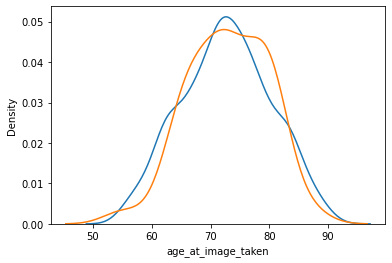

In [65]:
import seaborn as sns
sns.kdeplot(data=H[H['event_col']==0], x='age_at_image_taken')
sns.kdeplot(data=H[H['event_col']==1], x='age_at_image_taken')

<AxesSubplot:xlabel='norm_AD_imaging_score', ylabel='Density'>

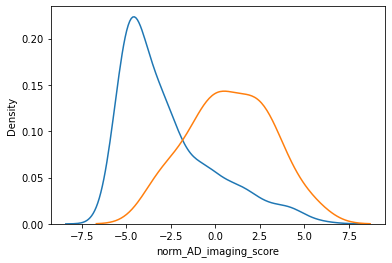

In [66]:
sns.kdeplot(data=H[H['event_col']==0], x='norm_AD_imaging_score')
sns.kdeplot(data=H[H['event_col']==1], x='norm_AD_imaging_score')

<AxesSubplot:xlabel='time_from_diagnosis', ylabel='norm_AD_imaging_score'>

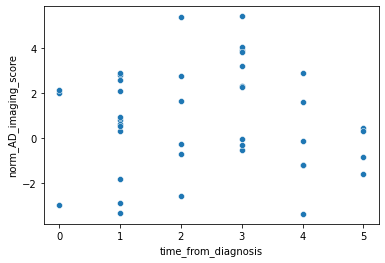

In [76]:
sns.scatterplot(data=H[H['event_col']==1], y='norm_AD_imaging_score', x='time_from_diagnosis')

In [6]:
# auc_mean_test[auc_mean_test[name_event]]

In [15]:
list(D_RESULTS)

['PD-Sex + PD_prs + Age_at_image_taken + norm_PD_imaging_score',
 'PD-Sex + PD_prs + Age_at_image_taken',
 'PD-Sex + Age_at_image_taken',
 'PD-norm_PD_imaging_score',
 'ALL_DEMENTIA-Sex + AD_prs + Age_at_image_taken + norm_AD_imaging_score',
 'ALL_DEMENTIA-Sex + AD_prs + Age_at_image_taken',
 'ALL_DEMENTIA-Sex + Age_at_image_taken',
 'ALL_DEMENTIA-norm_AD_imaging_score',
 'MCI-age_at_image_taken + sex + brainVolume + norm_AD_imaging_score',
 'MCI-age_at_image_taken + sex + brainVolume',
 'MCI-norm_AD_imaging_score']

In [20]:
np.sum(D_RESULTS['PD-Sex + PD_prs + Age_at_image_taken + norm_PD_imaging_score']['y_test_m'] == D_RESULTS['PD-Sex + PD_prs + Age_at_image_taken']['y_test_m'])

rec.array(4996,
          dtype=int64)

In [ ]:
y_test_m = D_RESULTS['PD-Sex + PD_prs + Age_at_image_taken + norm_PD_imaging_score']['y_test_m']
cph_risk_scores = [D_RESULTS[key]["cph_risk_scores"] for key in D_RESULTS if 'PD' in key]


PD-Sex + PD_prs + Age_at_image_taken + norm_PD_imaging_score
PD-Sex + PD_prs + Age_at_image_taken
PD-Sex + Age_at_image_taken
PD-norm_PD_imaging_score


In [25]:
np.sum(auc_mean_test_less3[0] == auc_mean_test_less3[1])

rec.array(4975,
          dtype=int64)

In [28]:
F = get_all_scores(y_test_m_less3[0], auc_mean_test_less3[0], cph_risk_scores_less3, percentile = (20, 80))


  5%|██████████▊                                                                                                                                                                                                 | 53/1000 [00:05<01:44,  9.10it/s]

KeyboardInterrupt: 

In [ ]:
OUTPUT[f'{key}<3'] = get_all_scores(y_test_m, auc_mean_test, risk_scores, percentile = (20, 80))
    
    
    auc_mean_test = y_test_m[(y_test_m[name_time]>=3) | (y_test_m[name_event]==False)]
    risk_scores = cph_risk_scores[(y_test_m[name_time]>=3) | (y_test_m[name_event]==False)]
    # auc_mean_test = y_test_m[(y_test_m[name_time]>=3)]
    # risk_scores = cph_risk_scores[(y_test_m[name_time]>=3)
    OUTPUT[f'{key}>=3'] = get_all_scores(y_test_m, auc_mean_test, risk_scores, percentile = (20, 80))

In [7]:
OUTPUT = {}
for key in D_RESULTS:
    break
    print (key)
    cph_risk_scores = D_RESULTS[key]["cph_risk_scores"]
    y_test_m = D_RESULTS[key]["y_test_m"]
    survival_function = D_RESULTS[key]["survival_function"]
    name_event, name_time = y_test_m.dtype.names
    auc_mean_test = y_test_m[y_test_m[name_time]>=0]
    risk_scores = cph_risk_scores[y_test_m[name_time]>=0]
    OUTPUT[f'{key}>=0'] = get_all_scores(y_test_m, auc_mean_test, [risk_scores, ], percentile = (20, 80))

In [8]:
# name_event, name_time = y_test_m.dtype.names
# auc_mean_test = y_test_m[(y_test_m[name_time]<3)]
# y_test_m[(y_test_m[name_time]<3) | (y_test_m[name_event]==False)]

In [ ]:
for key in D_RESULTS:
    if 'MCI' in key:
        continue
    # cph_risk_scores = D_RESULTS['PD-Sex + PD_prs + Age_at_image_taken + norm_PD_imaging_score']["cph_risk_scores"]
    # y_test_m = D_RESULTS['PD-Sex + PD_prs + Age_at_image_taken + norm_PD_imaging_score']["y_test_m"]
    print (key)
    cph_risk_scores = D_RESULTS[key]["cph_risk_scores"]
    y_test_m = D_RESULTS[key]["y_test_m"]
    name_event, name_time = y_test_m.dtype.names
    auc_mean_test = y_test_m[(y_test_m[name_time]<3) | (y_test_m[name_event]==False)]
    risk_scores = cph_risk_scores[(y_test_m[name_time]<3) | (y_test_m[name_event]==False)]
    OUTPUT[f'{key}<3'] = get_all_scores(y_test_m, auc_mean_test, risk_scores, percentile = (20, 80))
    auc_mean_test = y_test_m[(y_test_m[name_time]>=3) | (y_test_m[name_event]==False)]
    risk_scores = cph_risk_scores[(y_test_m[name_time]>=3) | (y_test_m[name_event]==False)]
    # auc_mean_test = y_test_m[(y_test_m[name_time]>=3)]
    # risk_scores = cph_risk_scores[(y_test_m[name_time]>=3)
    OUTPUT[f'{key}>=3'] = get_all_scores(y_test_m, auc_mean_test, risk_scores, percentile = (20, 80))

In [9]:
# auc_mean_test.shape, y_test_m.shape, risk_scores.shape

In [10]:
for key in D_RESULTS:
    if 'MCI' in key:
        continue
    # cph_risk_scores = D_RESULTS['PD-Sex + PD_prs + Age_at_image_taken + norm_PD_imaging_score']["cph_risk_scores"]
    # y_test_m = D_RESULTS['PD-Sex + PD_prs + Age_at_image_taken + norm_PD_imaging_score']["y_test_m"]
    print (key)
    cph_risk_scores = D_RESULTS[key]["cph_risk_scores"]
    y_test_m = D_RESULTS[key]["y_test_m"]
    name_event, name_time = y_test_m.dtype.names
    auc_mean_test = y_test_m[(y_test_m[name_time]<3) | (y_test_m[name_event]==False)]
    risk_scores = cph_risk_scores[(y_test_m[name_time]<3) | (y_test_m[name_event]==False)]
    OUTPUT[f'{key}<3'] = get_all_scores(y_test_m, auc_mean_test, risk_scores, percentile = (20, 80))
    auc_mean_test = y_test_m[(y_test_m[name_time]>=3) | (y_test_m[name_event]==False)]
    risk_scores = cph_risk_scores[(y_test_m[name_time]>=3) | (y_test_m[name_event]==False)]
    # auc_mean_test = y_test_m[(y_test_m[name_time]>=3)]
    # risk_scores = cph_risk_scores[(y_test_m[name_time]>=3)
    OUTPUT[f'{key}>=3'] = get_all_scores(y_test_m, auc_mean_test, risk_scores, percentile = (20, 80))

PD-Sex + PD_prs + Age_at_image_taken + norm_PD_imaging_score


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:27<00:00, 36.54it/s]


mean_auc,cindex,cindex_ipcw
0.85 [0.8-0.93],0.85 [0.8-0.91],0.9 [0.86-0.95]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:26<00:00, 38.36it/s]


mean_auc,cindex,cindex_ipcw
0.91 [0.86-0.96],0.91 [0.88-0.95],0.95 [0.92-1.0]
PD-Sex + PD_prs + Age_at_image_taken


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:27<00:00, 36.69it/s]


mean_auc,cindex,cindex_ipcw
0.83 [0.77-0.9],0.82 [0.76-0.89],0.87 [0.83-0.93]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:26<00:00, 38.41it/s]


mean_auc,cindex,cindex_ipcw
0.89 [0.84-0.95],0.9 [0.85-0.94],0.94 [0.91-1.0]
PD-Sex + Age_at_image_taken


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:26<00:00, 38.16it/s]


mean_auc,cindex,cindex_ipcw
0.83 [0.78-0.89],0.82 [0.76-0.89],0.87 [0.83-0.93]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:25<00:00, 39.92it/s]


mean_auc,cindex,cindex_ipcw
0.88 [0.83-0.94],0.89 [0.84-0.93],0.94 [0.9-1.0]
PD-norm_PD_imaging_score


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:27<00:00, 36.55it/s]


mean_auc,cindex,cindex_ipcw
0.65 [0.49-0.83],0.67 [0.55-0.79],0.75 [0.68-0.84]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:26<00:00, 38.15it/s]


mean_auc,cindex,cindex_ipcw
0.77 [0.66-0.88],0.74 [0.65-0.83],0.63 [0.47-0.77]
ALL_DEMENTIA-Sex + AD_prs + Age_at_image_taken + norm_AD_imaging_score


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:29<00:00, 34.16it/s]


mean_auc,cindex,cindex_ipcw
0.82 [0.7-0.96],0.86 [0.78-0.94],0.86 [0.81-0.92]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:28<00:00, 34.74it/s]


mean_auc,cindex,cindex_ipcw
0.91 [0.86-0.98],0.9 [0.85-0.97],0.96 [0.94-1.0]
ALL_DEMENTIA-Sex + AD_prs + Age_at_image_taken


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:28<00:00, 35.12it/s]


mean_auc,cindex,cindex_ipcw
0.79 [0.68-0.92],0.82 [0.75-0.9],0.82 [0.75-0.91]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:28<00:00, 35.09it/s]


mean_auc,cindex,cindex_ipcw
0.9 [0.84-0.98],0.88 [0.83-0.95],0.95 [0.93-1.0]
ALL_DEMENTIA-Sex + Age_at_image_taken


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:27<00:00, 36.31it/s]


mean_auc,cindex,cindex_ipcw
0.79 [0.7-0.89],0.81 [0.75-0.88],0.81 [0.74-0.9]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:27<00:00, 36.56it/s]


mean_auc,cindex,cindex_ipcw
0.9 [0.85-0.97],0.89 [0.84-0.94],0.95 [0.93-1.0]
ALL_DEMENTIA-norm_AD_imaging_score


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:28<00:00, 35.08it/s]


mean_auc,cindex,cindex_ipcw
0.77 [0.6-0.95],0.82 [0.72-0.93],0.77 [0.64-0.91]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 672/1000 [00:19<00:09, 33.91it/s]

KeyboardInterrupt: 

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 672/1000 [00:38<00:09, 33.91it/s]

In [14]:
auc_mean_test

rec.array([( True, 4.10136986), (False, 2.70136986), (False, 2.2109589 ),
           ..., (False, 2.83287671), (False, 2.23013699),
           (False, 2.35342466)],
          dtype=[('Status_daysFromDiagnosis_image_taken_PD', '?'), ('daysFromDiagnosis_image_taken_PD', '<f8')])

In [15]:
risk_scores

array([14.76117239, 13.74452949, 15.02447203, ..., 12.83215965,
       13.93093081, 11.3947536 ])

In [11]:
import pickle
with open('Step3_survival_analysis/new_survival_bootstrapped_auc_results.pickle', 'wb') as handle:
    pickle.dump(OUTPUT, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [12]:
list(OUTPUT)

['PD-Sex + PD_prs + Age_at_image_taken + norm_PD_imaging_score>=0',
 'PD-Sex + PD_prs + Age_at_image_taken>=0',
 'ALL_DEMENTIA-Sex + AD_prs + Age_at_image_taken + norm_AD_imaging_score>=0',
 'ALL_DEMENTIA-Sex + AD_prs + Age_at_image_taken>=0',
 'MCI-age_at_image_taken + sex + brainVolume + norm_AD_imaging_score>=0',
 'MCI-age_at_image_taken + sex + brainVolume>=0',
 'PD-Sex + PD_prs + Age_at_image_taken + norm_PD_imaging_score<3',
 'PD-Sex + PD_prs + Age_at_image_taken + norm_PD_imaging_score>=3',
 'PD-Sex + PD_prs + Age_at_image_taken<3',
 'PD-Sex + PD_prs + Age_at_image_taken>=3',
 'ALL_DEMENTIA-Sex + AD_prs + Age_at_image_taken + norm_AD_imaging_score<3',
 'ALL_DEMENTIA-Sex + AD_prs + Age_at_image_taken + norm_AD_imaging_score>=3',
 'ALL_DEMENTIA-Sex + AD_prs + Age_at_image_taken<3',
 'ALL_DEMENTIA-Sex + AD_prs + Age_at_image_taken>=3']

In [13]:
import numpy as np
from scipy import stats
# rng = np.random.default_rng()
# stats.ttest_ind(rvs1, rvs2)

In [14]:
rvs1 = OUTPUT['PD-Sex + PD_prs + Age_at_image_taken + norm_PD_imaging_score>=0'][0]['mean_auc']
rvs2 = OUTPUT['PD-Sex + PD_prs + Age_at_image_taken>=0'][0]['mean_auc']
print (">=0", stats.ttest_ind(rvs1, rvs2))
rvs1 = OUTPUT['PD-Sex + PD_prs + Age_at_image_taken + norm_PD_imaging_score<3'][0]['mean_auc']
rvs2 = OUTPUT['PD-Sex + PD_prs + Age_at_image_taken<3'][0]['mean_auc']
print ("<3", stats.ttest_ind(rvs1, rvs2))
rvs1 = OUTPUT['PD-Sex + PD_prs + Age_at_image_taken + norm_PD_imaging_score>=3'][0]['mean_auc']
rvs2 = OUTPUT['PD-Sex + PD_prs + Age_at_image_taken>=3'][0]['mean_auc']
print (">=3", stats.ttest_ind(rvs1, rvs2))

>=0 Ttest_indResult(statistic=18.139762184096085, pvalue=3.395069920741052e-68)
<3 Ttest_indResult(statistic=18.418767338584093, pvalue=4.242792425345686e-70)
>=3 Ttest_indResult(statistic=15.923558911390856, pvalue=7.72671092488026e-54)


In [15]:
rvs1 = OUTPUT['ALL_DEMENTIA-Sex + AD_prs + Age_at_image_taken + norm_AD_imaging_score>=0'][0]['mean_auc']
rvs2 = OUTPUT['ALL_DEMENTIA-Sex + AD_prs + Age_at_image_taken>=0'][0]['mean_auc']
print (">=0", stats.ttest_ind(rvs1, rvs2))
rvs1 = OUTPUT['ALL_DEMENTIA-Sex + AD_prs + Age_at_image_taken + norm_AD_imaging_score<3'][0]['mean_auc']
rvs2 = OUTPUT['ALL_DEMENTIA-Sex + AD_prs + Age_at_image_taken<3'][0]['mean_auc']
print ("<3", stats.ttest_ind(rvs1, rvs2))
rvs1 = OUTPUT['ALL_DEMENTIA-Sex + AD_prs + Age_at_image_taken + norm_AD_imaging_score>=3'][0]['mean_auc']
rvs2 = OUTPUT['ALL_DEMENTIA-Sex + AD_prs + Age_at_image_taken>=3'][0]['mean_auc']
print (">=3", stats.ttest_ind(rvs1, rvs2))

>=0 Ttest_indResult(statistic=16.97964337798834, pvalue=1.6556442822352021e-60)
<3 Ttest_indResult(statistic=20.112346532307317, pvalue=4.450165879106355e-82)
>=3 Ttest_indResult(statistic=9.813039339797038, pvalue=3.1176399872621315e-22)


In [17]:
list(D_RESULTS['PD-Sex + PD_prs + Age_at_image_taken + norm_PD_imaging_score'])

['survival_function',
 'cph_risk_scores',
 'input_data_survival',
 'test_index_list_m',
 'y_test_m']

In [21]:
P

,Sex,PD_prs,Age_at_image_taken,norm_PD_imaging_score,daysFromDiagnosis_image_taken_PD,Status_daysFromDiagnosis_image_taken_PD
eid,,,,,,
3156969,1,1.625070,75,1.955149,2.646575,1
2134986,0,0.084505,75,0.069778,0.013699,1
4268575,1,-0.432579,65,2.421448,1.065753,1
4282130,0,1.642390,72,2.030145,0.438356,1
2212241,0,-0.782810,69,1.088613,4.101370,1
...,...,...,...,...,...,...
2095158,0,-1.494230,53,1.651110,2.257534,0
2095688,1,-0.529820,64,1.111961,2.684932,0
3144400,0,-0.475160,58,0.580079,2.832877,0


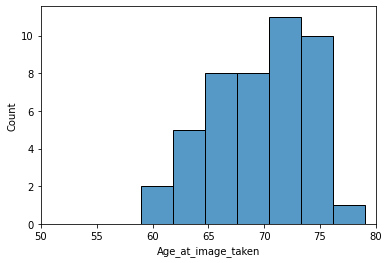

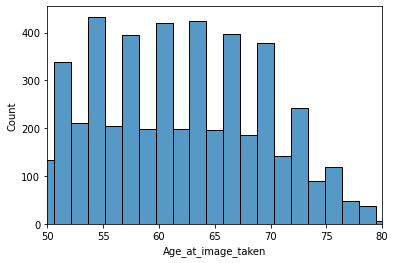

In [29]:
import seaborn as sns
P = D_RESULTS['PD-Sex + PD_prs + Age_at_image_taken + norm_PD_imaging_score']['input_data_survival']
P1 = P[P['Status_daysFromDiagnosis_image_taken_PD']==1]
P2 = P[~(P['Status_daysFromDiagnosis_image_taken_PD']==1)]

sns.histplot(x=P1['Age_at_image_taken'])
plt.xlim(50, 80)
plt.show()
sns.histplot(x=P2['Age_at_image_taken'])
plt.xlim(50, 80)
plt.show()
# sns.histplot(x=P2['Status_daysFromDiagnosis_image_taken_PD'])
# plt.show()

In [ ]:
rvs1 = OUTPUT['PD-Sex + PD_prs + Age_at_image_taken + norm_PD_imaging_score>=3'][0]['mean_auc']
rvs2 = OUTPUT['PD-Sex + PD_prs + Age_at_image_taken>=3'][0]['mean_auc']
stats.ttest_ind(rvs1, rvs2)

In [82]:
rvs1 = OUTPUT['PD-Sex + PD_prs + Age_at_image_taken + norm_PD_imaging_score>=3'][0]['mean_auc']
rvs2 = OUTPUT['PD-Sex + PD_prs + Age_at_image_taken>=3'][0]['mean_auc']
stats.ttest_ind(rvs1, rvs2)

{'mean_auc': 0.8288507005631969}

In [ ]:
rvs1 = OUTPUT['PD-Sex + PD_prs + Age_at_image_taken + norm_PD_imaging_score>=3'][0]['mean_auc']
rvs2 = OUTPUT['PD-Sex + PD_prs + Age_at_image_taken>=3'][0]['mean_auc']
stats.ttest_ind(rvs1, rvs2)

In [67]:
from collections import defaultdict

def get_all_metrics_cis(y_test, y_probas, decision_threshold):
    np.random.seed(13)
    mapping_scores = []
    mapping_scores.append(get_alls(y_test, np.array(y_probas[:, 1] > decision_threshold)))
    scores = defaultdict(list)
    types_scores = "sensitivity,specificity,precision,npv,fnr,tpr,fpr,tnr,fdr,acc,bal_acc,f1score,ppv".split(',')
    for stype in types_scores:
        scores[stype].append(mapping_scores[0][stype])

    met=[ get_alls ]
    X_metrics_cm = raw_metric_samples(met, y_test, np.array(y_probas[:, 1] > decision_threshold), nboots=1000)
    X_def = defaultdict(list)
    for i in range(len(X_metrics_cm.columns)):
        for key, val in X_metrics_cm.iloc[0][i].items():
            X_def[key].append(val)

    X_def = pd.DataFrame(X_def)

    ci_mean = defaultdict(list)
    for col in X_def.columns:
        # ci_lower_auc = np.quantile(X_def[col], 0.025)
        # ci_upper_auc = np.quantile(X_def[col], 0.975)
        # mean_auc = scores[col][0]# np.mean(X_def[col])
        # print (mean_auc-ci_lower_auc, ci_upper_auc-mean_auc)
        # ci_mean[col].append(f"{round(mean_auc,2)} [{round(ci_lower_auc, 2)}-{round(ci_upper_auc,2)}]")
        
        mean_auc = scores[col][0]
        temp = X_def[col] - mean_auc
        # import pdb; pdb.set_trace()
        ci_lower_auc = mean_auc - np.quantile(temp, 0.975)
        ci_upper_auc = mean_auc - np.quantile(temp, 0.025)
        ci_mean[col].append(f"{round(mean_auc,2)} [{round(ci_lower_auc, 2)}-{round(ci_upper_auc,2)}]")


    ci_mean = pd.DataFrame(ci_mean)

    print (','.join(ci_mean.columns))
    print (','.join(ci_mean.iloc[0]))
    print ("N=", len(y_test), sum(y_test))






  0%|                                                                                                                                                                                                                       | 0/10 [00:00<?, ?it/s]




 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 5/10 [00:00<00:00, 41.47it/s]




100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 43.66it/s]

0.771125181491727
0.8374890309337785
0.8503600599259963
0.8617916746235019
0.8334494082006586
0.8316874958544745
0.8510054936663062
0.8430563159168312
0.8383527926451734
0.7686377243538081


In [69]:
X_metrics_cm

,0,1,2,3,4,5,6,7,8,9
Metric (class 1 +ve),,,,,,,,,,
Get Cumulative Dynamic Auc,0.771125,0.837489,0.85036,0.861792,0.833449,0.831687,0.851005,0.843056,0.838353,0.768638


In [59]:
auc_mean_test.shape, risk_scores.shape

((4159,), (4159,))

In [63]:
# auc_mean_test





  0%|                                                                                                                                                                                                                       | 0/10 [00:00<?, ?it/s]

TypeError: void() takes exactly 1 positional argument (0 given)

In [37]:
percentile = (20, 80)
auc_mean_test = y_test_m[y_test_m[name_time]<3]
risk_scores = cph_risk_scores[y_test_m[name_time]<3]
va_times = np.unique(np.percentile(auc_mean_test[name_time], np.linspace(percentile[0], percentile[1], 40)))
auc, mean_auc = cumulative_dynamic_auc(y_test_m, auc_mean_test, risk_scores, va_times)
mean_auc

0.8288507005631969

In [43]:
y_test_m.shape, auc_mean_test.shape, risk_scores.shape

((4996,), (4159,), (4159,))

In [39]:
met = [get_cumulative_dynamic_auc]
X_metrics_cm = raw_metric_samples(met, y_test_m, auc_mean_test, risk_scores, va_times, nboots=10)

ValueError: All arrays must be of the same length

In [ ]:
va_times = np.unique(np.percentile(y_test_m[y_test_m[name_event]][name_time], np.linspace(percentile[0], percentile[1], 40)))
auc, mean_auc = cumulative_dynamic_auc(y_test_m, y_test_m, cph_risk_scores, va_times)

In [35]:
percentile = (20, 80)
auc_mean_test = y_test_m[y_test_m[name_time]>3]
risk_scores = cph_risk_scores[y_test_m[name_time]>3]
va_times = np.unique(np.percentile(auc_mean_test[name_time], np.linspace(percentile[0], percentile[1], 40)))

In [36]:
auc, mean_auc = cumulative_dynamic_auc(y_test_m, auc_mean_test, risk_scores, va_times)
mean_auc

0.9256382492087459

In [24]:
y_test_m[y_test_m[name_time]<3]

rec.array([( True, 2.64657534), ( True, 0.01369863), ( True, 1.06575342),
           ..., (False, 2.83287671), (False, 2.23013699),
           (False, 2.35342466)],
          dtype=[('Status_daysFromDiagnosis_image_taken_PD', '?'), ('daysFromDiagnosis_image_taken_PD', '<f8')])

<AxesSubplot:ylabel='Count'>

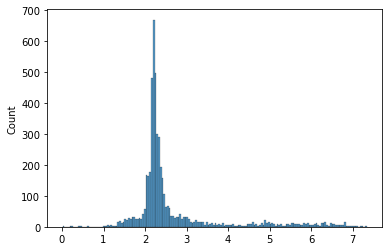

In [15]:
import seaborn as sns
sns.histplot(x=y_test_m["daysFromDiagnosis_image_taken_PD"])

In [ ]:
risk_score, label, y_test_m, y_test_new

In [7]:
# y_test_m

In [ ]:
# save results
            
            # print (pd.DataFrame(results).mean())
            
            
            get_auc_ci(y_test_m, y_predictions_m)
            name_event, name_time = y_test_m.dtype.names
            
            met=[ metrics.roc_auc_score]
            X_metrics_cm = raw_metric_samples(met, np.concatenate(y_true_values_list), np.concatenate(y_probas_list)[:, 1], nboots=1000)
            ci_mean = defaultdict(list)

            mean_auc = metrics.roc_auc_score(np.concatenate(y_true_values_list), np.concatenate(y_probas_list)[:, 1]) 
            temp = X_metrics_cm.loc['Roc Auc'].values - mean_auc
            ci_lower_auc = mean_auc - np.quantile(temp, 0.975)
            ci_upper_auc = mean_auc - np.quantile(temp, 0.025)
            ci_mean['Roc Auc'].append(f"{round(mean_auc,2)} [{round(ci_lower_auc, 2)}-{round(ci_upper_auc,2)}]")

            ci_mean = pd.DataFrame(ci_mean)
            print (','.join(ci_mean.columns))
            print (','.join(ci_mean.iloc[0]))
            selected_index = [i for i in range(len(test_input_data_survival))]
            name_event, name_time = y_test_m.dtype.names
            y_test_new = y_test_m
            
            # cph_auc, cph_mean_auc = cumulative_dynamic_auc(y_test_new, y_test_new, test_input_data_survival['norm_PD_imaging_score'], va_times)
            # for e, col in enumerate(list(set(list_variable_of_interest + formula.split(' + ')))):# ['adjusted_norm_AD_imaging_score', 'AD_prs', 'Sex']):
            #     plot_cumulative_dynamic_auc(test_input_data_survival.iloc[selected_index][col].values, col, y_test_m, y_test_m[selected_index], percentile=(20, 80), color="C{}".format(e))
            
            dict_times[f"{disease}-{enm}"], dict_auc[f"{disease}-{enm}"] = plot_cumulative_dynamic_auc(y_predictions_m[selected_index], f"joint-{disease}-{enm}", y_test_m, y_test_m[selected_index], percentile=(20, 80), color="C{}".format(enm+1))
            enm += 1
plt.show()